<a href="https://colab.research.google.com/github/KonstantinosKounakis/SegElegansOnline/blob/JoVE-prep/SegElegans%20Body%20Prediction%20Interface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jun 10 10:23:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#@title **Install dependencies**
#@markdown It will take a few minutes.
!python -m pip install -U roifile
!pip install joblib
!pip install file-split-merge
!pip install imagecodecs
!pip install tifffile
!git clone -b JoVE-prep --single-branch https://github.com/KonstantinosKounakis/SegElegansOnline.git
%cd /content/SegElegansOnline/
from utils import *

def get_image_network(device, dir_checkpoint, n_classes, in_size, image_gray, batch_img):
    model = UMF_ConvLSTM(n_channels=1, n_classes=n_classes, bilinear=True, type_net=1)
    model.load_state_dict(torch.load(dir_checkpoint))
    model.eval()
    model.to(device=device)

    h, w = image_gray.shape
    h_steps = setps_crop(h, in_size, 3)
    w_steps = setps_crop(w, in_size, 3)
    list_box = []
    for i in h_steps:
        for j in w_steps:
            crop = [i, i + in_size, j, j + in_size]
            list_box.append(crop)

    n_crops = len(list_box)
    n_reps = 1
    f = 0
    while f == 0:
        if (batch_img * n_reps) < n_crops:
            n_reps = n_reps + 1
        else:
            f = 1

    if n_classes == 1:
        masK_img = np.zeros((h, w), dtype="uint8")

    if n_classes == 4:
        masK_img = np.zeros((h, w, 3), dtype="uint8")

    with torch.no_grad():
        cnt_crops1 = 0
        cnt_crops2 = 0
        for i in range(n_reps):
            masK_crops = np.zeros((h, w), dtype="uint8")
            for j in range(batch_img):
                if cnt_crops1 < n_crops:
                    image_i = image_gray[list_box[cnt_crops1][0]:list_box[cnt_crops1][1], list_box[cnt_crops1][2]:list_box[cnt_crops1][3]]
                    image_i = np.expand_dims(image_i, axis=0)
                    masK_crops = update_mask(masK_crops, image_i)
                    cnt_crops1 = cnt_crops1 + 1

            image_i = torch.from_numpy(masK_crops).to(device=device, dtype=torch.float32).unsqueeze(1)
            image_i = model(image_i)
            image_i = (torch.sigmoid(image_i) > 0.5) * 255
            image_i = image_i.cpu().numpy().astype('uint8')

            for j in range(batch_img):
                if cnt_crops2 < n_crops:
                    if n_classes == 1:
                        masK_img[list_box[cnt_crops2][0]:list_box[cnt_crops2][1], list_box[cnt_crops2][2]:list_box[cnt_crops2][3]] = image_i[j, :, :, :]

                    if n_classes == 4:
                        masK_img[list_box[cnt_crops2][0]:list_box[cnt_crops2][1], list_box[cnt_crops2][2]:list_box[cnt_crops2][3], 0] = image_i[j, 1, :, :]
                        masK_img[list_box[cnt_crops2][0]:list_box[cnt_crops2][1], list_box[cnt_crops2][2]:list_box[cnt_crops2][3], 1] = image_i[j, 2, :, :]
                        masK_img[list_box[cnt_crops2][0]:list_box[cnt_crops2][1], list_box[cnt_crops2][2]:list_box[cnt_crops2][3], 2] = image_i[j, 3, :, :]
                    cnt_crops2 = cnt_crops2 + 1

    del model, image_i, masK_crops
    gc.collect()
    torch.cuda.empty_cache()
    return masK_img

fatal: destination path 'SegElegansOnline' already exists and is not an empty directory.
/content/SegElegansOnline


In [4]:
#@title **Please, provide the necessary input files below:**

base = '/content/SegElegansOnline/'

checkpoint_SEG = '/content/SegElegansOnline/Models/Body/SEG/'

checkpoint_SKL = '/content/SegElegansOnline/Models/Body/SKL/'

test_images = '/content/drive/MyDrive/Eleganseg Test/Images' #@param {type:"string", placeholder:"Please specify folder with images"}
print('Input folder:', test_images)

save_dir = '/content/drive/MyDrive/Eleganseg Test/Output' #@param {type:"string", placeholder:"Please specify folder for outputs"}
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
print('Output:', save_dir)

Input folder: /content/drive/MyDrive/Eleganseg Test/Images
Output: /content/drive/MyDrive/Eleganseg Test/Output


In [5]:
#@title **Unzip networks, images**
import zipfile

# unzip networks
network_SEG = os.path.join(checkpoint_SEG, 'model.pth')
!file_split_merge -m -i $network_SEG

network_SKL = os.path.join(checkpoint_SKL, 'model.pth')
!file_split_merge -m -i $network_SKL

from Models.Body.UMF_ConvLSTM import UMF_ConvLSTM



------------- STARTING FILE MERGE -------------

Merging the file to /content/SegElegansOnline/Models/Body/SEG/model.pth
File Already Exist. Please remove the /content/SegElegansOnline/Models/Body/SEG/model.pth and then re-run.

Do you want to remove the file [Y/N] : y
Found 3 file(s) for merging
 - Merging model.pth-1.ros file
 - Merging model.pth-2.ros file
 - Merging model.pth-3.ros file
Checking if the files are merged properly
File check : Passed
File Merged successfully
Complete in 4 seconds

------------- STARTING FILE MERGE -------------

Merging the file to /content/SegElegansOnline/Models/Body/SKL/model.pth
File Already Exist. Please remove the /content/SegElegansOnline/Models/Body/SKL/model.pth and then re-run.

Do you want to remove the file [Y/N] : y
Found 3 file(s) for merging
 - Merging model.pth-1.ros file
 - Merging model.pth-2.ros file
 - Merging model.pth-3.ros file
Checking if the files are merged properly
File check : Passed
File Merged successfully
Complete in 3 

cuda


100%|██████████| 37/37 [00:03<00:00, 12.43img/s]

 
Image shown: Test (9).TIF


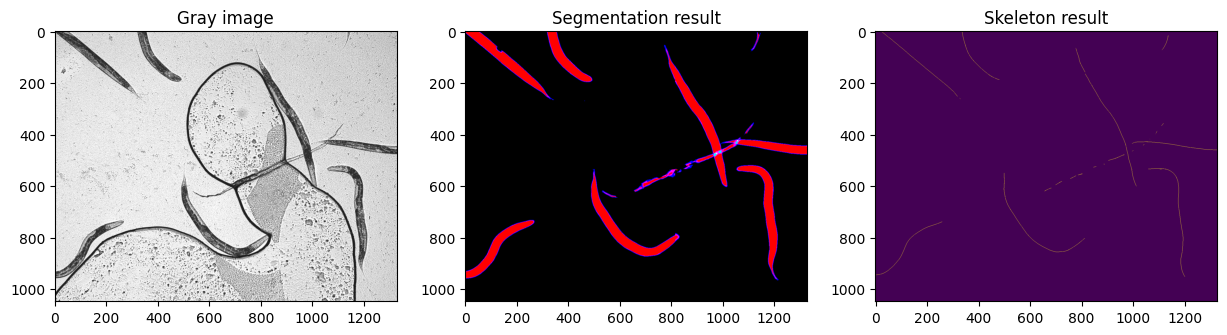

100%|██████████| 37/37 [00:06<00:00,  5.82img/s]


In [6]:
#@title **Begin Evaluating**

end_gray_image = '.TIF' #@param {type:"string", placeholder:"Specify the PRECISE extension of your images"}
batch_crop_img = 9 #@param {type:"slider", min:4, max:16, step:1}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

path_SKELETON = os.path.join(save_dir,'0_SKELETON/')
path_SEGMENTATION = os.path.join(save_dir,'0_SEGMENTATION/')

if not os.path.exists(path_SKELETON):
    os.makedirs(path_SKELETON)

if not os.path.exists(path_SEGMENTATION):
    os.makedirs(path_SEGMENTATION)

list_images = sorted(list_files(test_images, end_gray_image))

with tqdm(total=len(list_images), unit='img') as pbar:
    for name_image in list_images:
        # name_image = list_images[q]
        name_image_ = name_image.split('.')[0]
        name_image_save = name_image_ + '.bmp'
        path_image_gray = os.path.join(test_images, name_image)

        image_gray = np.asarray(Image.open(path_image_gray))  # read gray image
        if len(image_gray.shape) > 2:
            image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
        h, w = image_gray.shape

        if not os.path.exists(path_SEGMENTATION + name_image_save):
            # Obtain segmentation from Network1
            dir_checkpoint_seg = checkpoint_SEG + 'model.pth'
            image_seg = get_image_network(device=device, dir_checkpoint=dir_checkpoint_seg, n_classes=4,
                                            in_size=512, image_gray=image_gray, batch_img=batch_crop_img)

            # Obtain Skeleton from Network2
            dir_checkpoint_skl = checkpoint_SKL + 'model.pth'
            image_skl = get_image_network(device=device, dir_checkpoint=dir_checkpoint_skl, n_classes=1,
                                            in_size=512, image_gray=image_gray, batch_img=batch_crop_img)
            cv2.imwrite(path_SEGMENTATION + name_image_save, image_seg)
            cv2.imwrite(path_SKELETON + name_image_save, image_skl)
        else:
            image_seg = cv2.imread(path_SEGMENTATION + name_image_save)
            image_skl = cv2.imread(path_SKELETON + name_image_save, cv2.IMREAD_GRAYSCALE)
        pbar.update(1)

    print(' ')
    print('Image shown:', name_image)
    name_image_00 = name_image
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(131)
    ax1.title.set_text('Gray image')
    ax1.imshow(image_gray, cmap='gray', vmin=0, vmax=255)

    ax2 = fig.add_subplot(132)
    ax2.title.set_text('Segmentation result')
    ax2.imshow(image_seg)

    ax3 = fig.add_subplot(133)
    ax3.title.set_text('Skeleton result')
    ax3.imshow(image_skl)
    plt.show()

Folder complete mask: /content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask
Folder edge and small mask: /content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask
Folder overlap masks: /content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask
Folder save_results: /content/drive/MyDrive/Eleganseg Test/Output/0_summary_results


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  37 out of  37 | elapsed:  9.4min finished


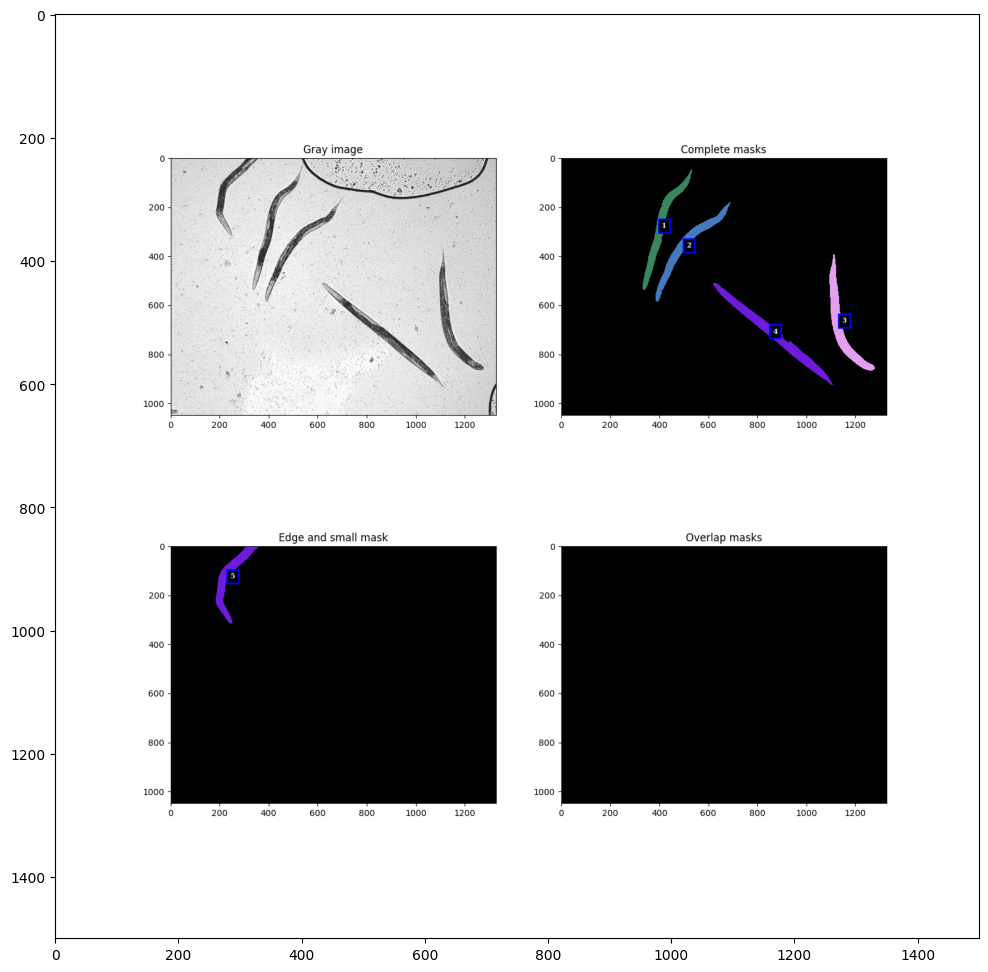

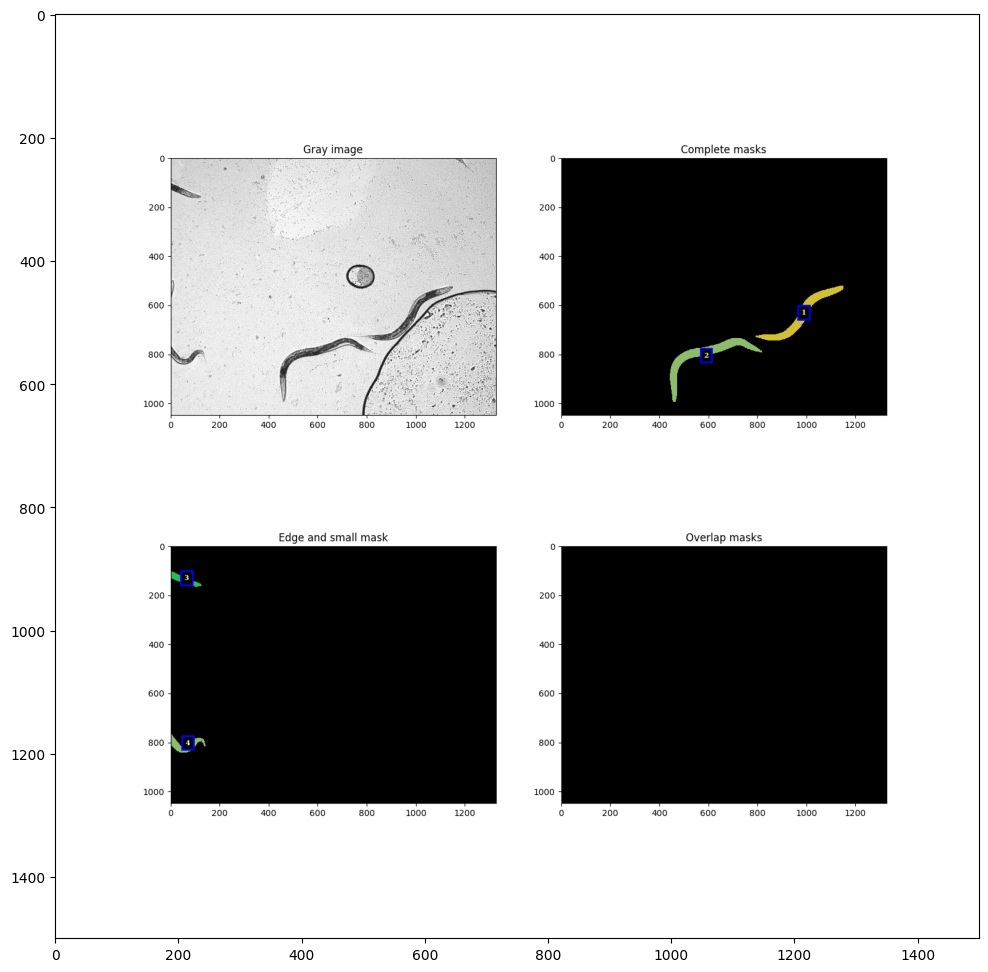

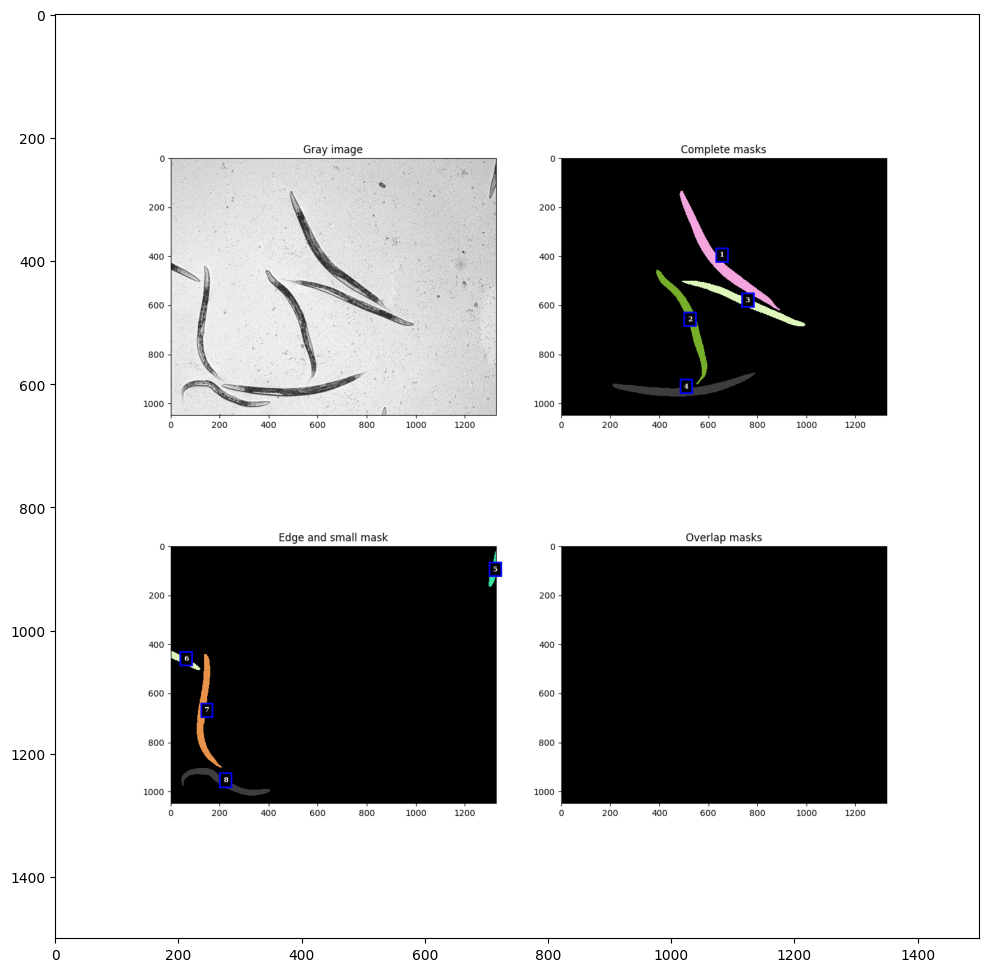

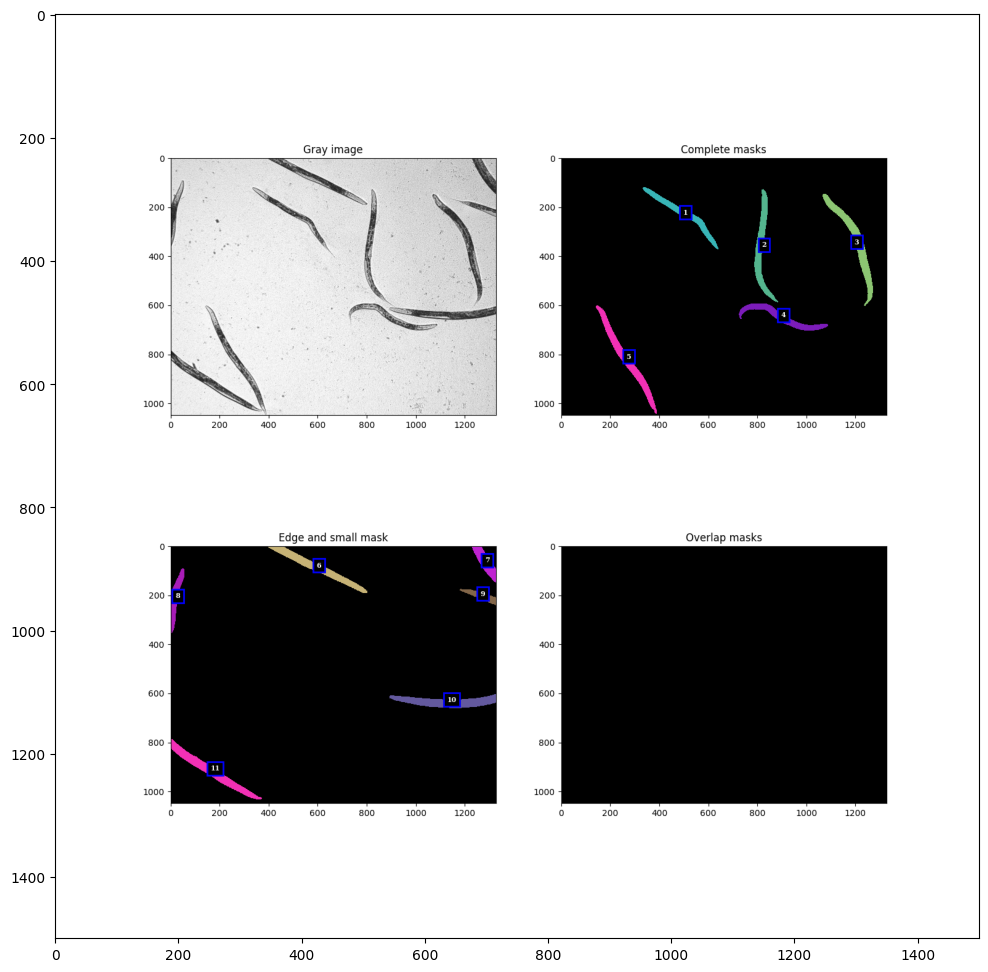

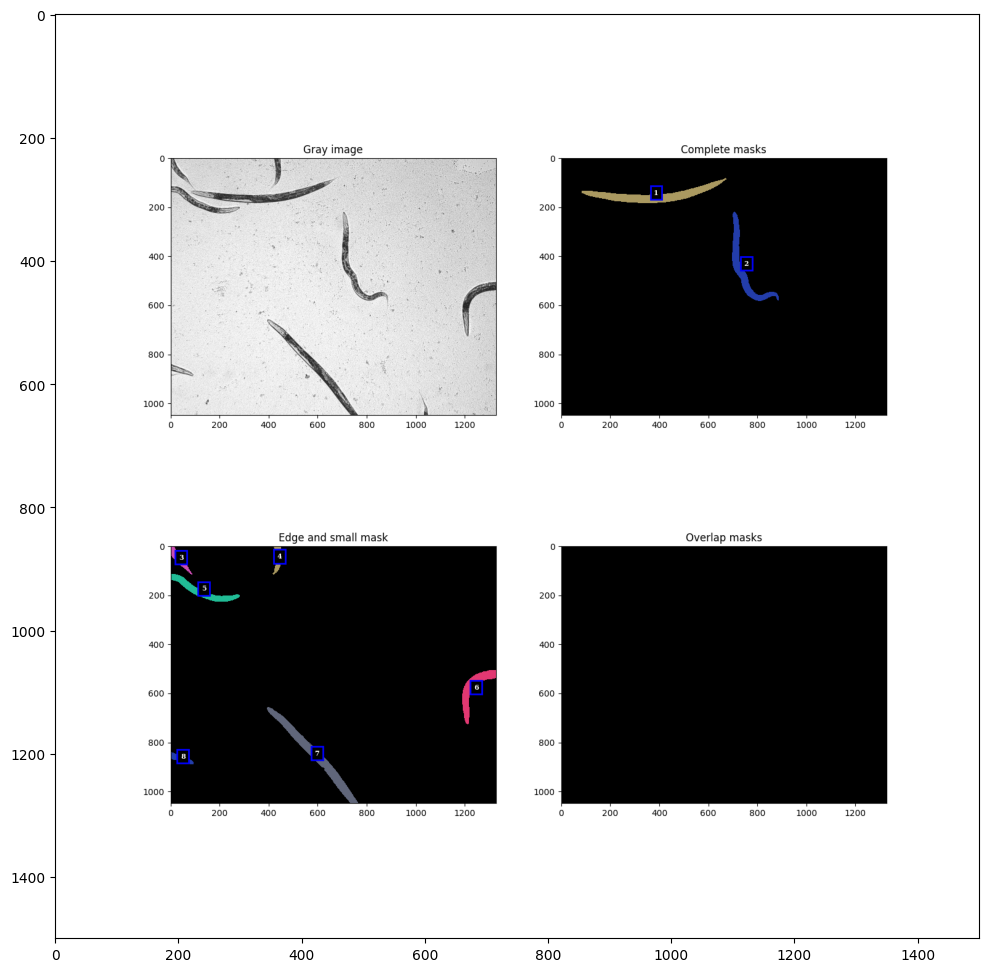

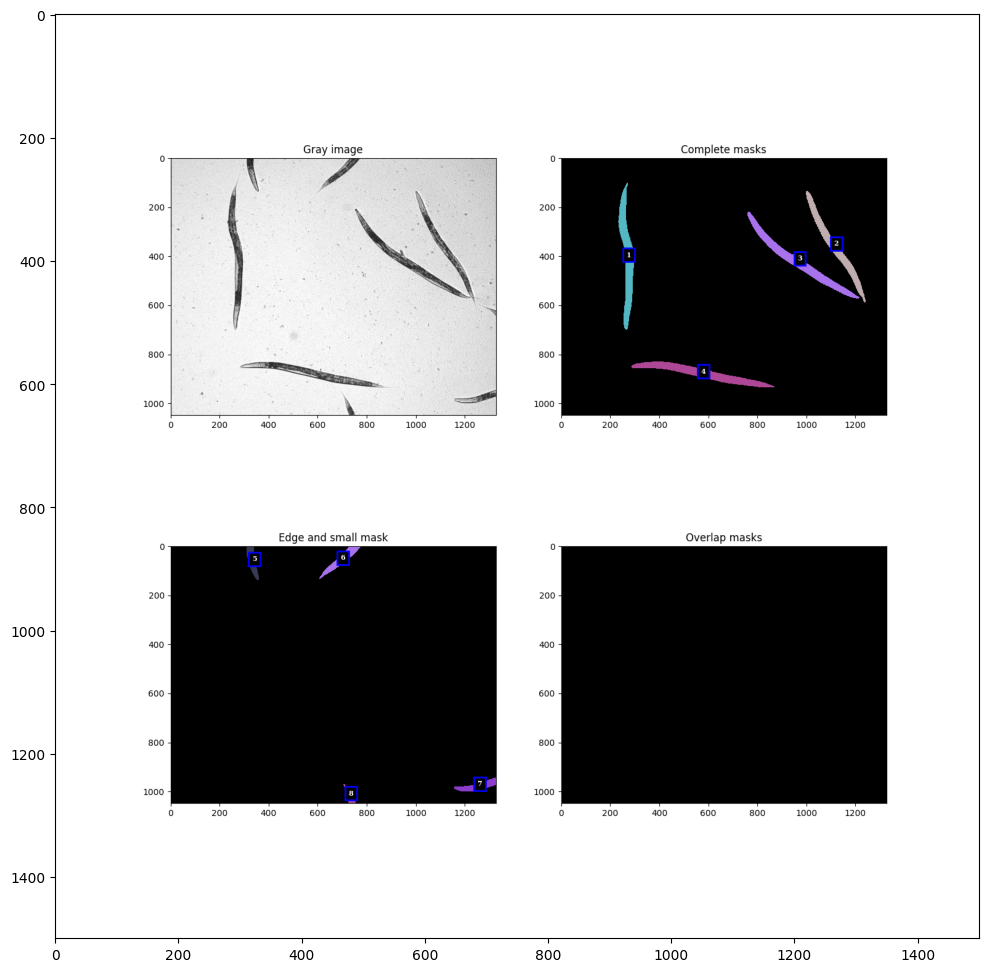

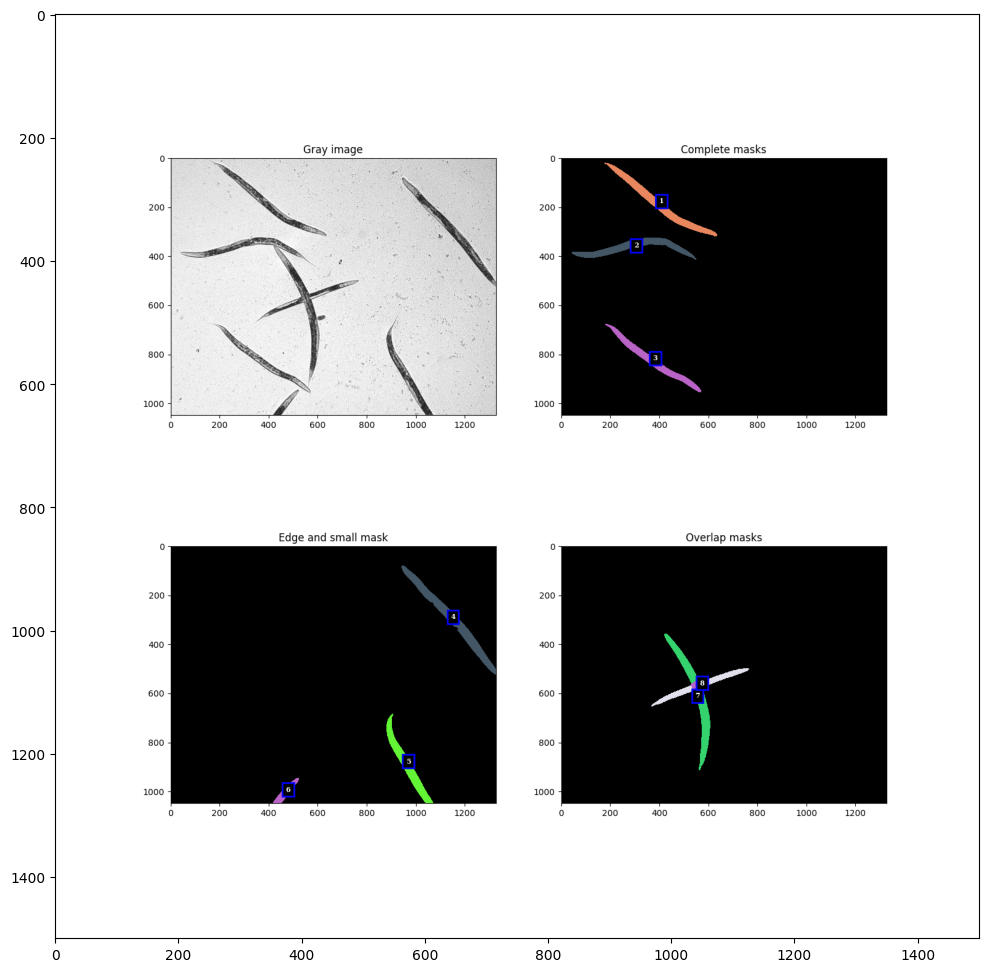

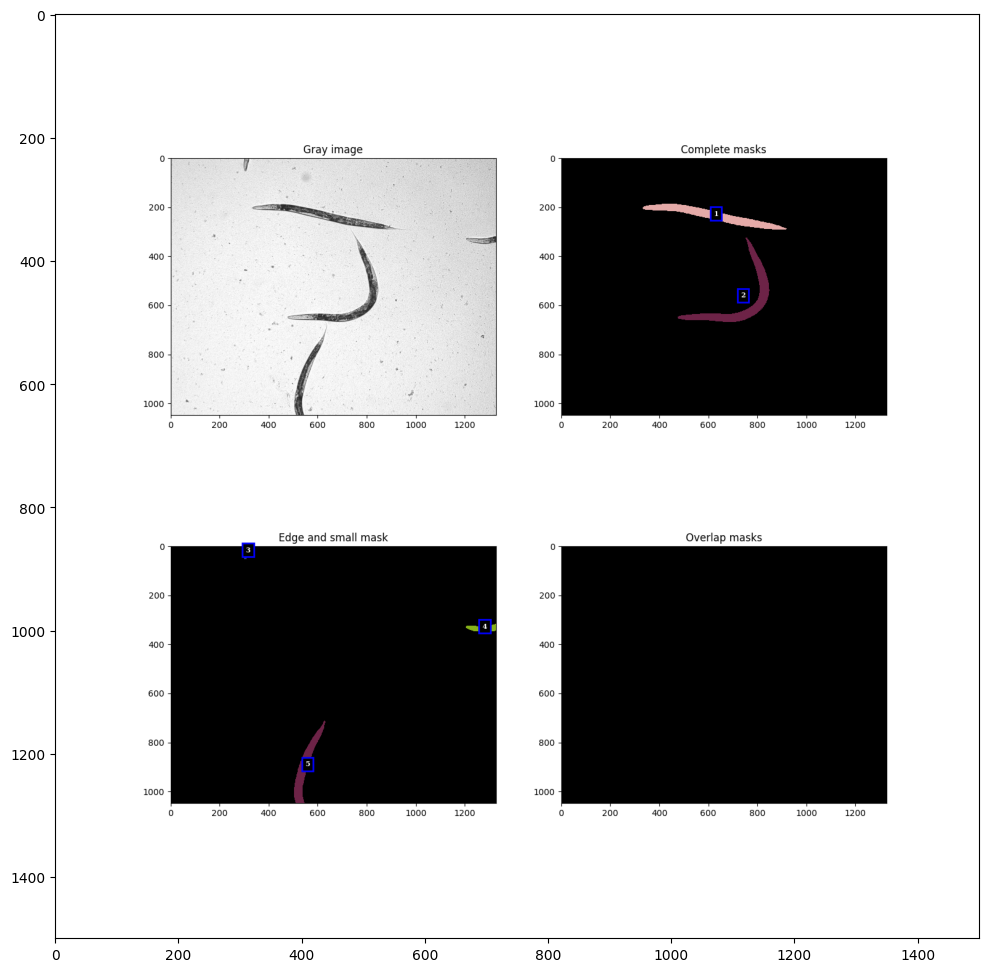

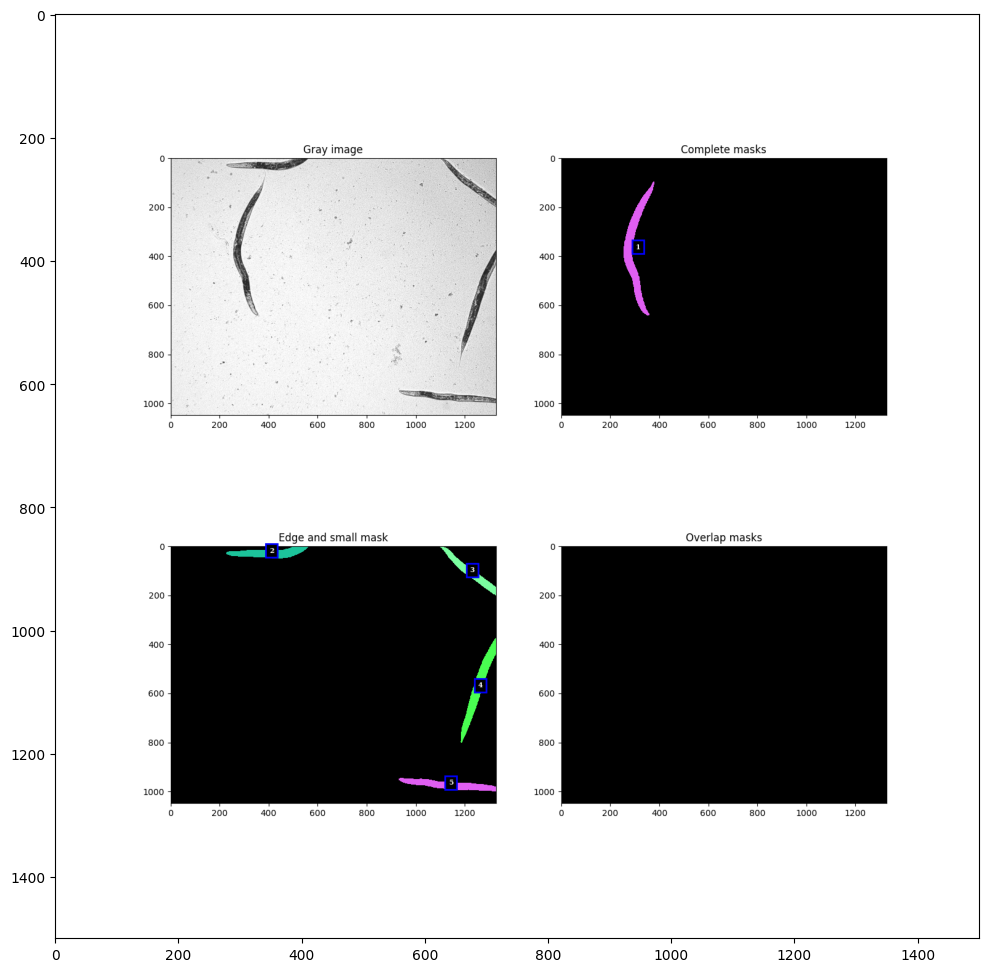

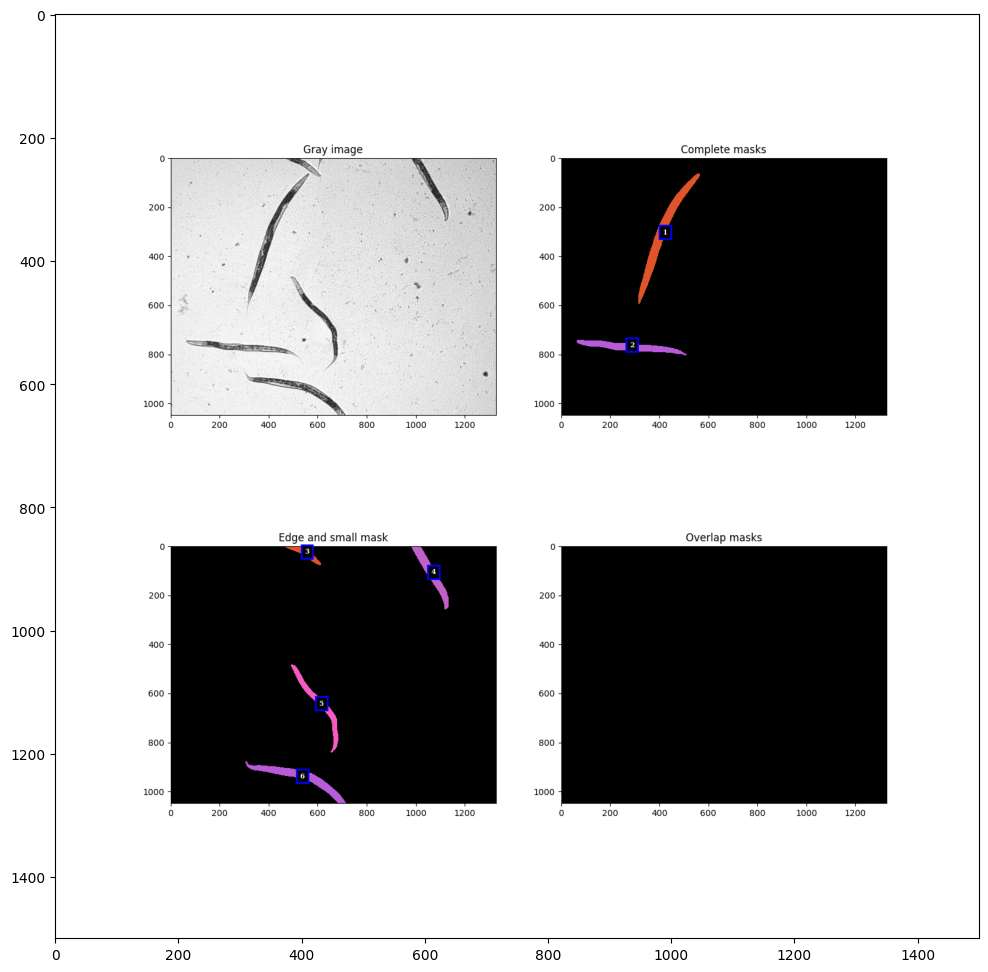

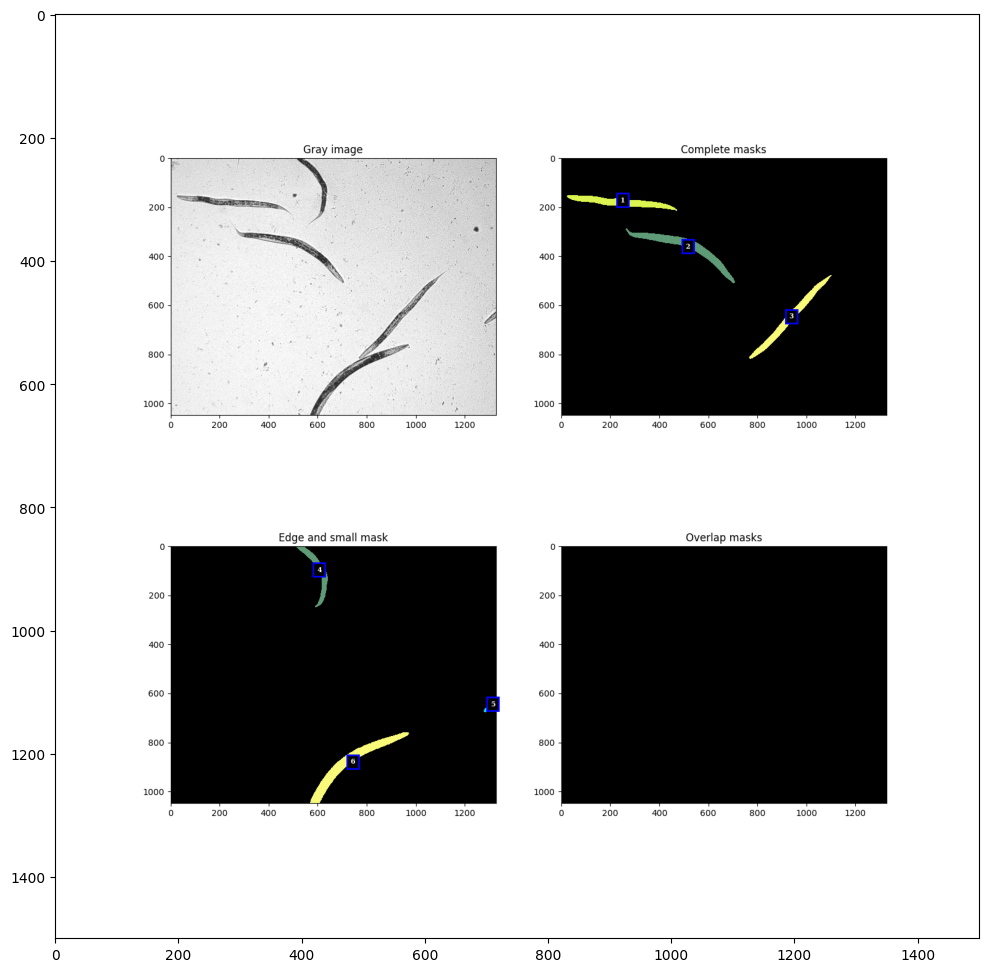

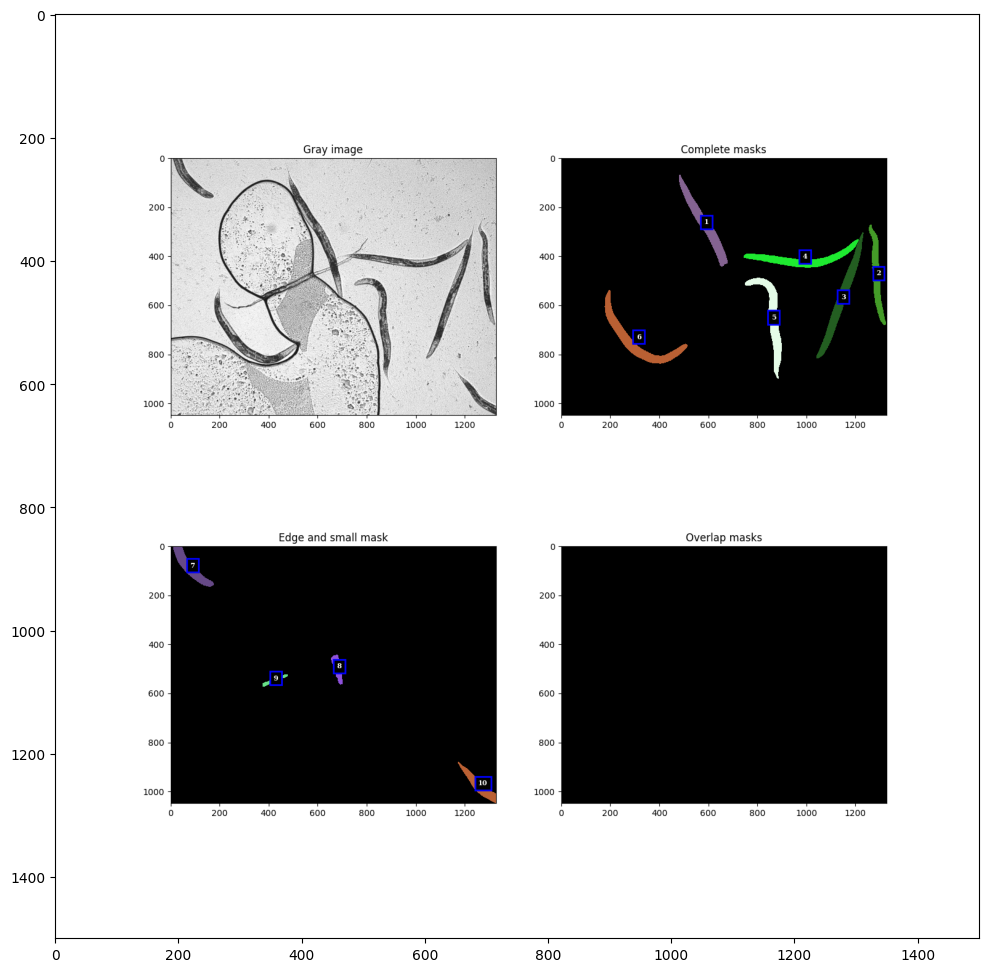

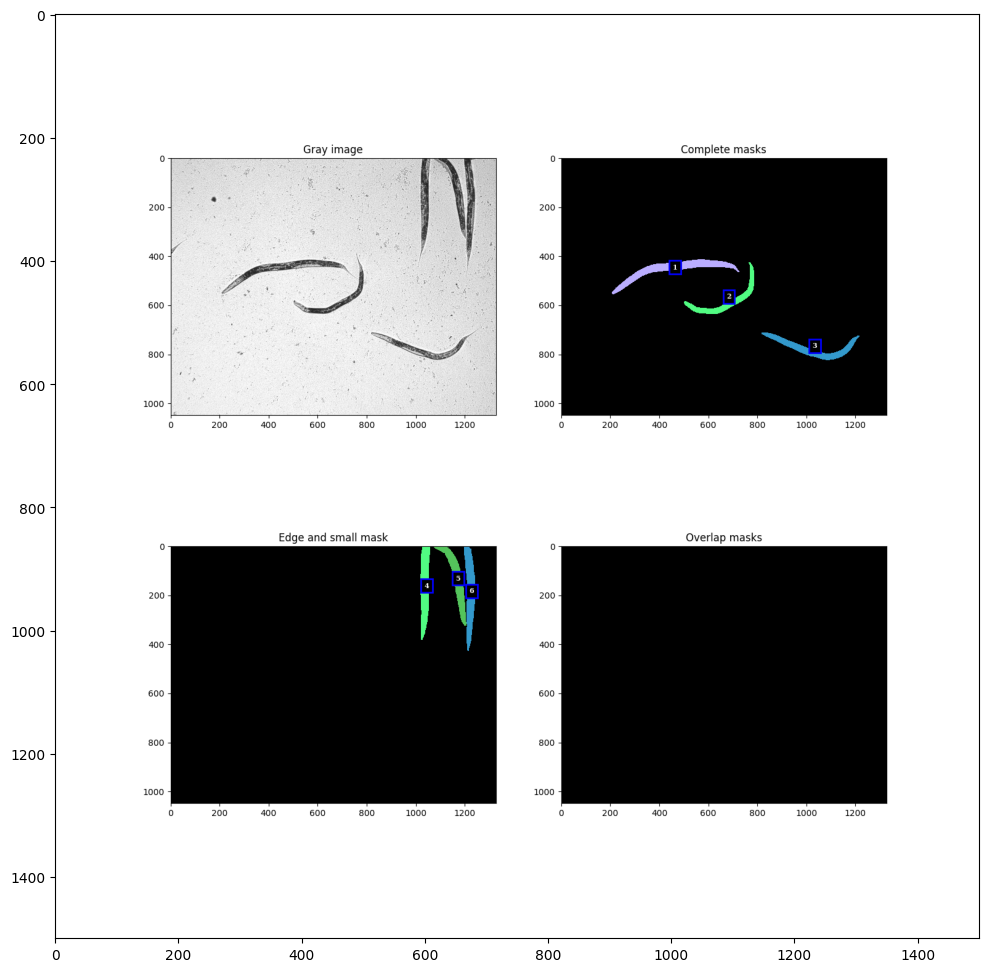

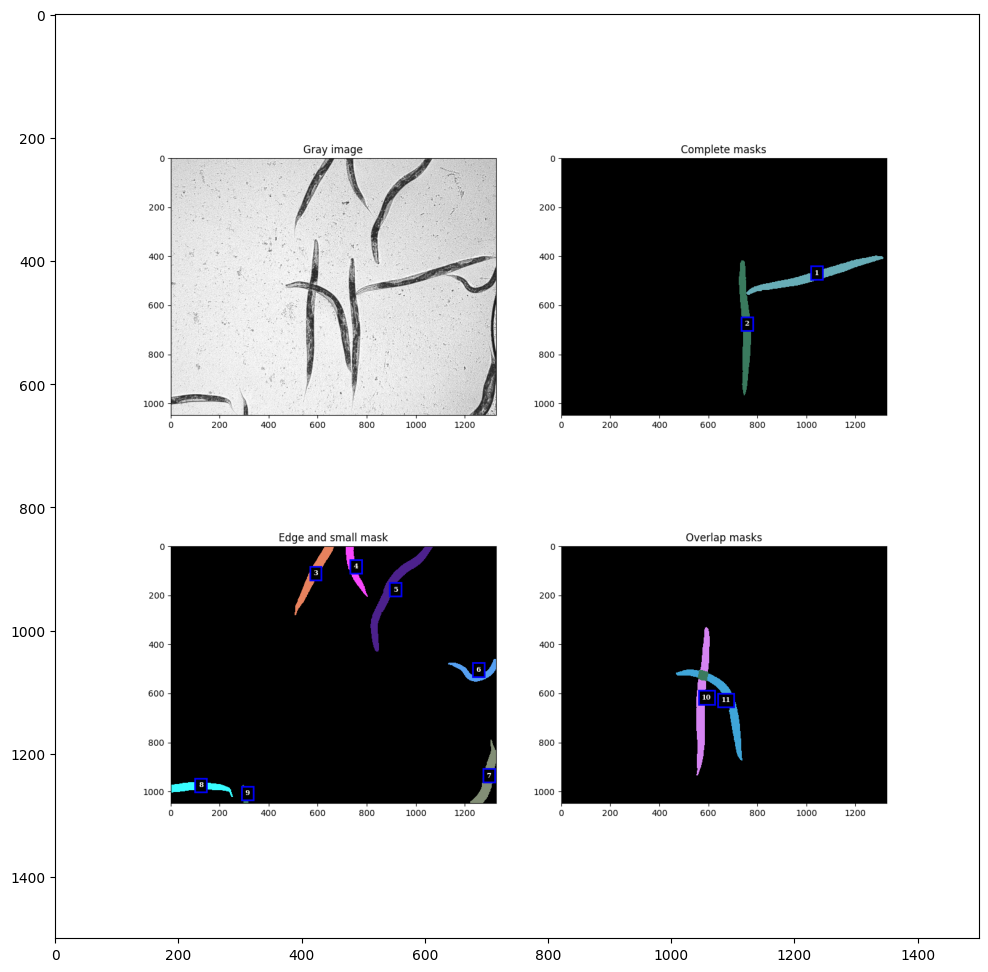

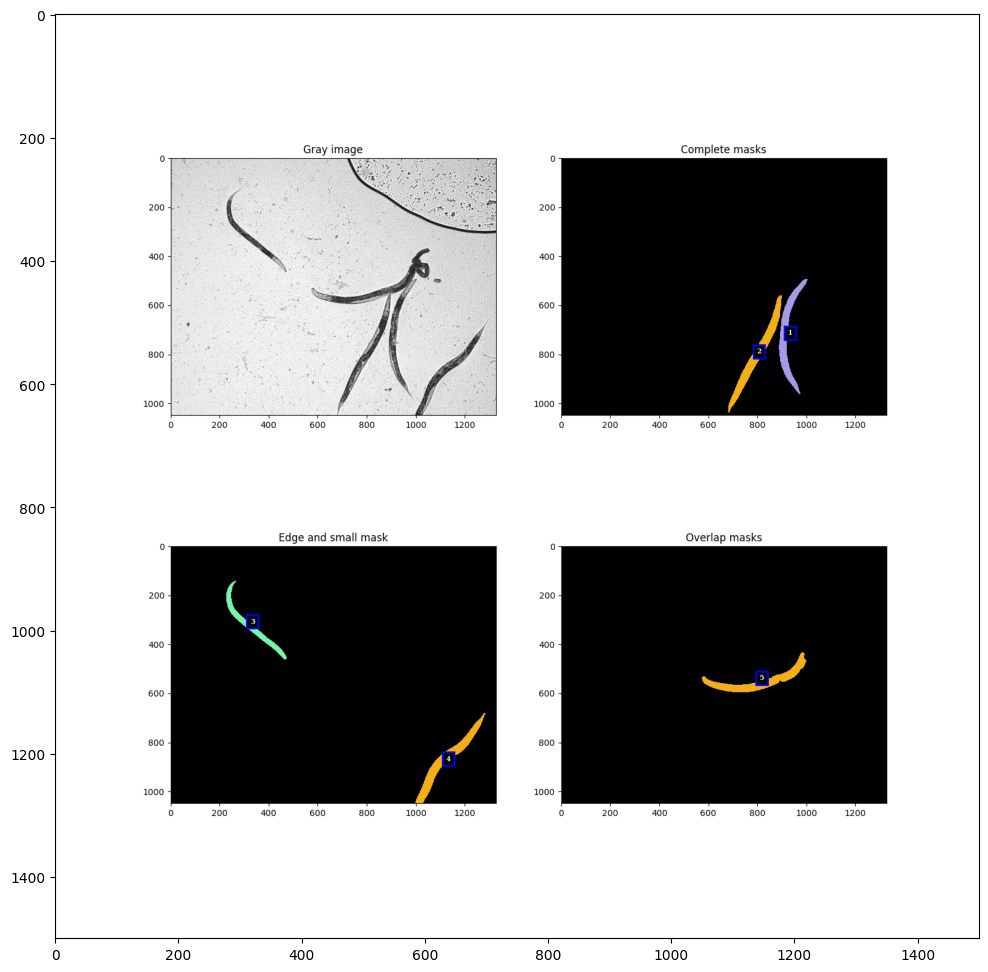

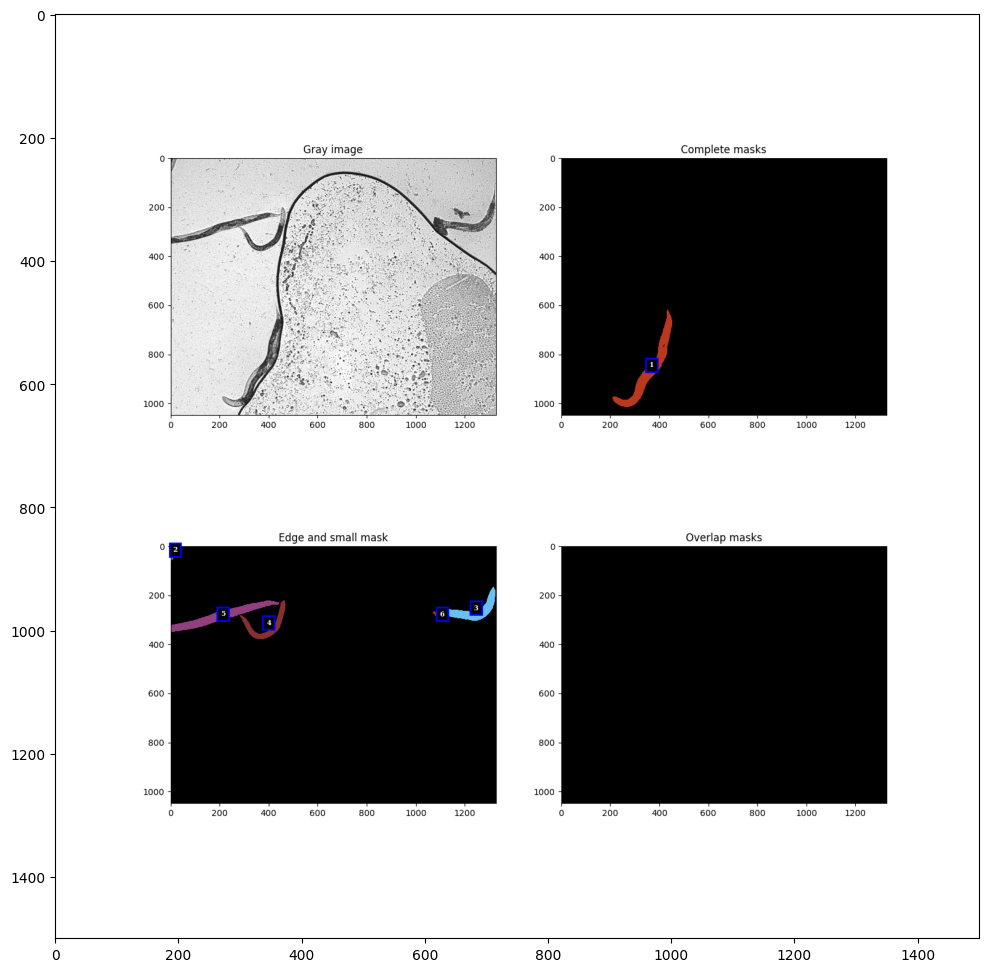

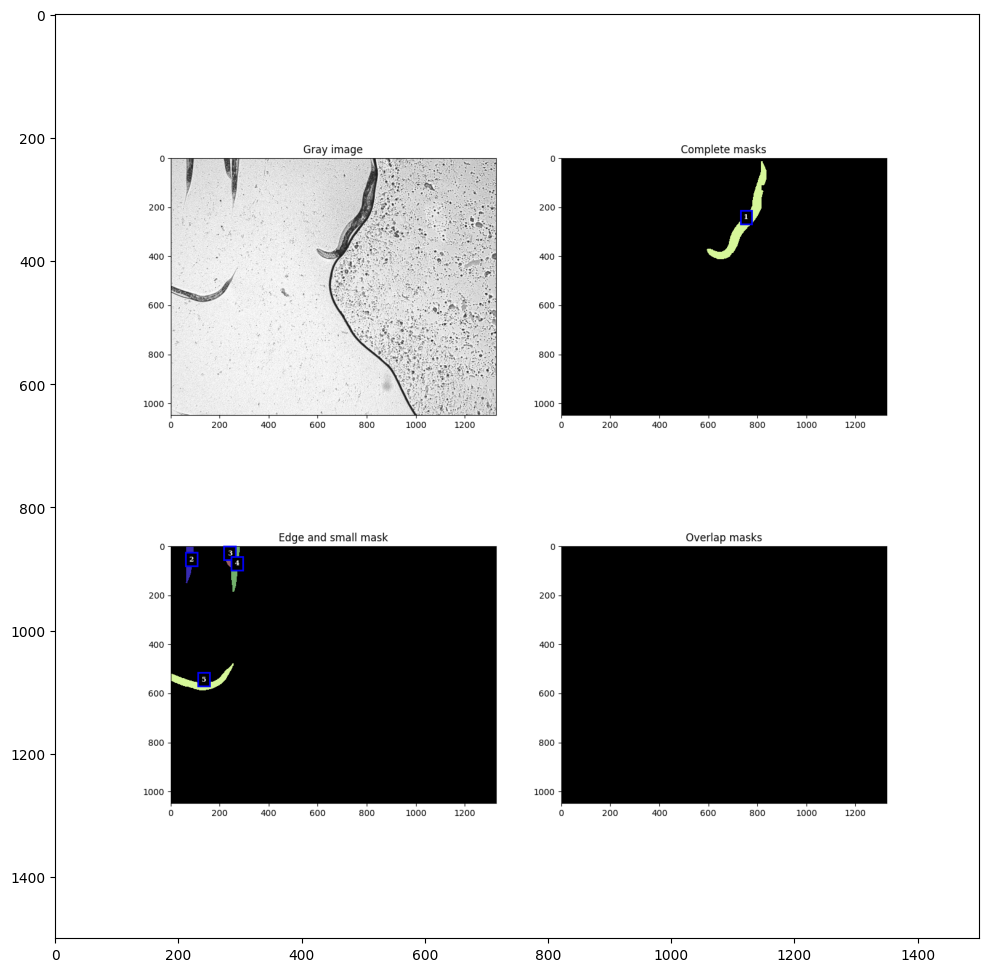

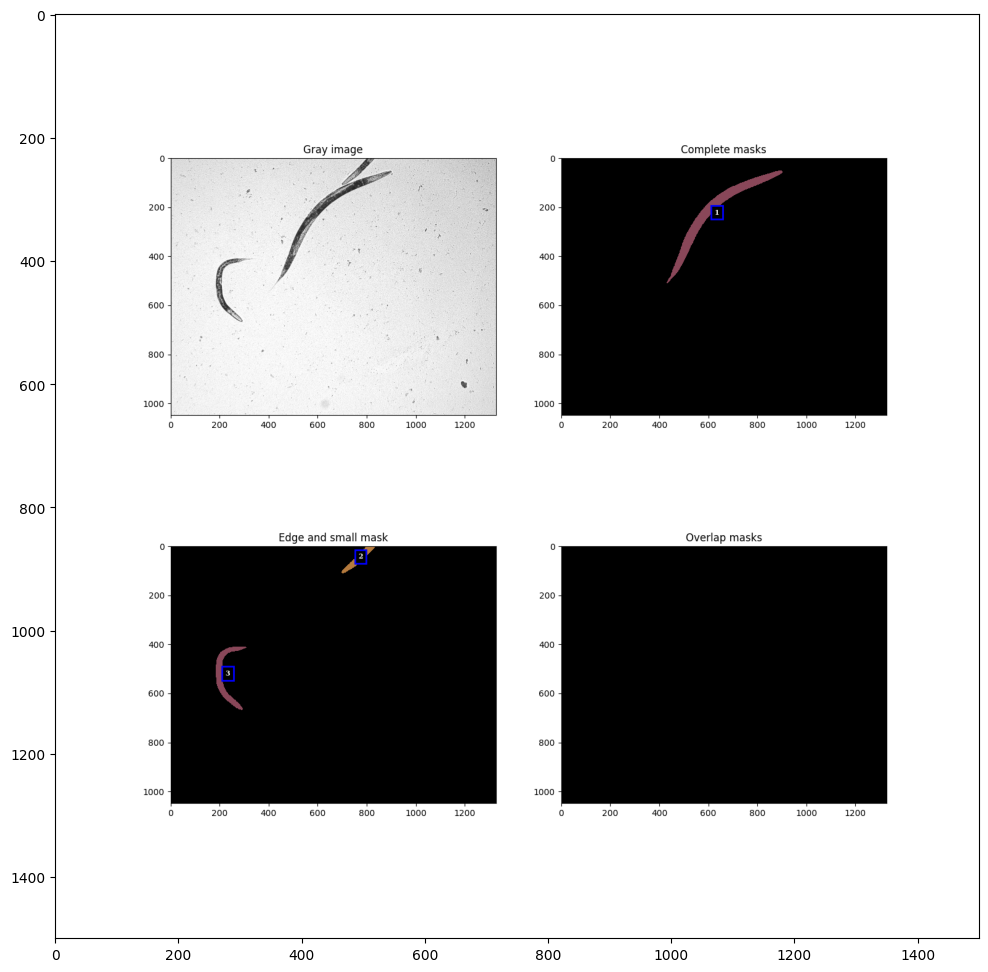

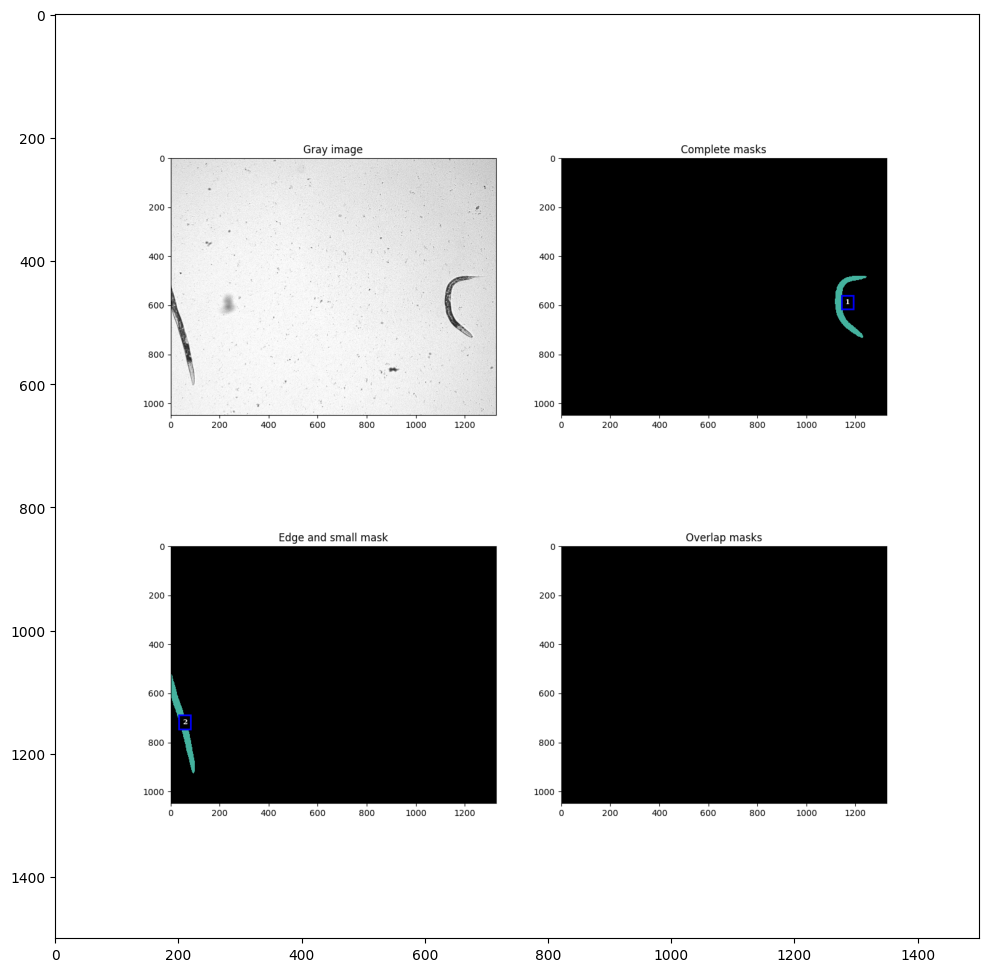

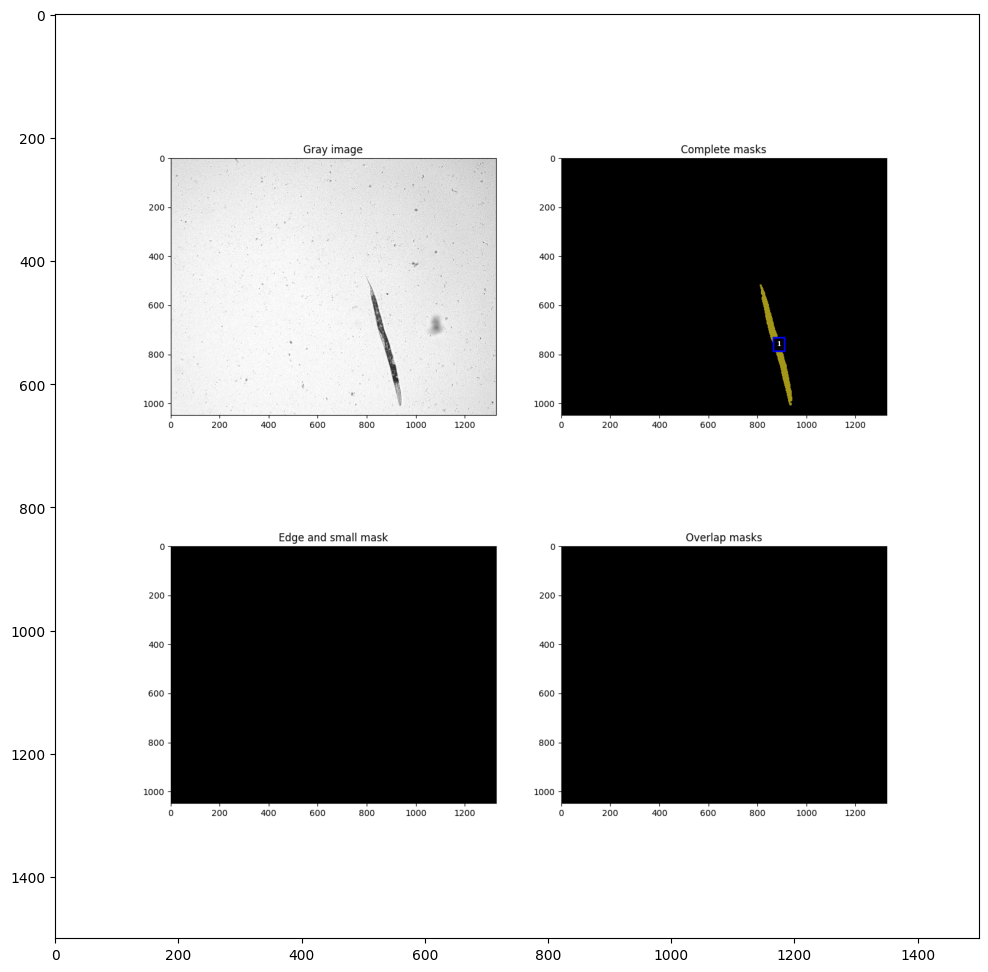

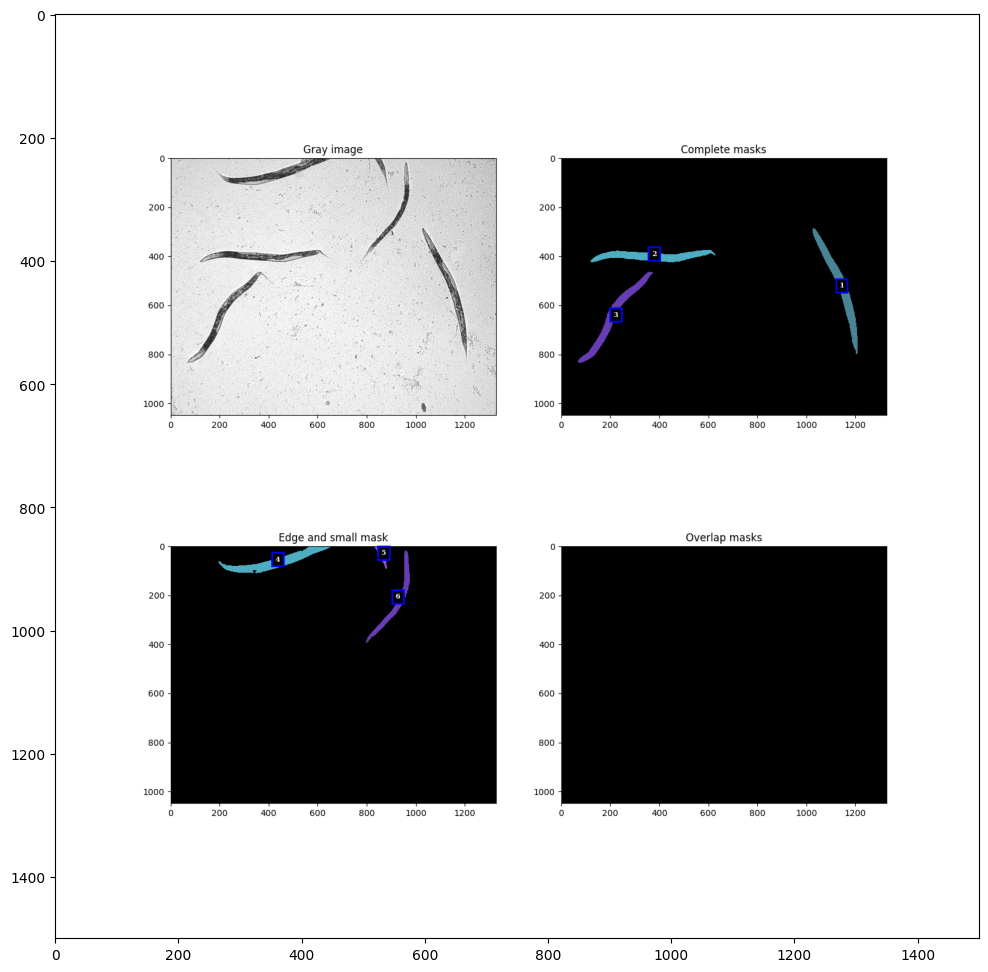

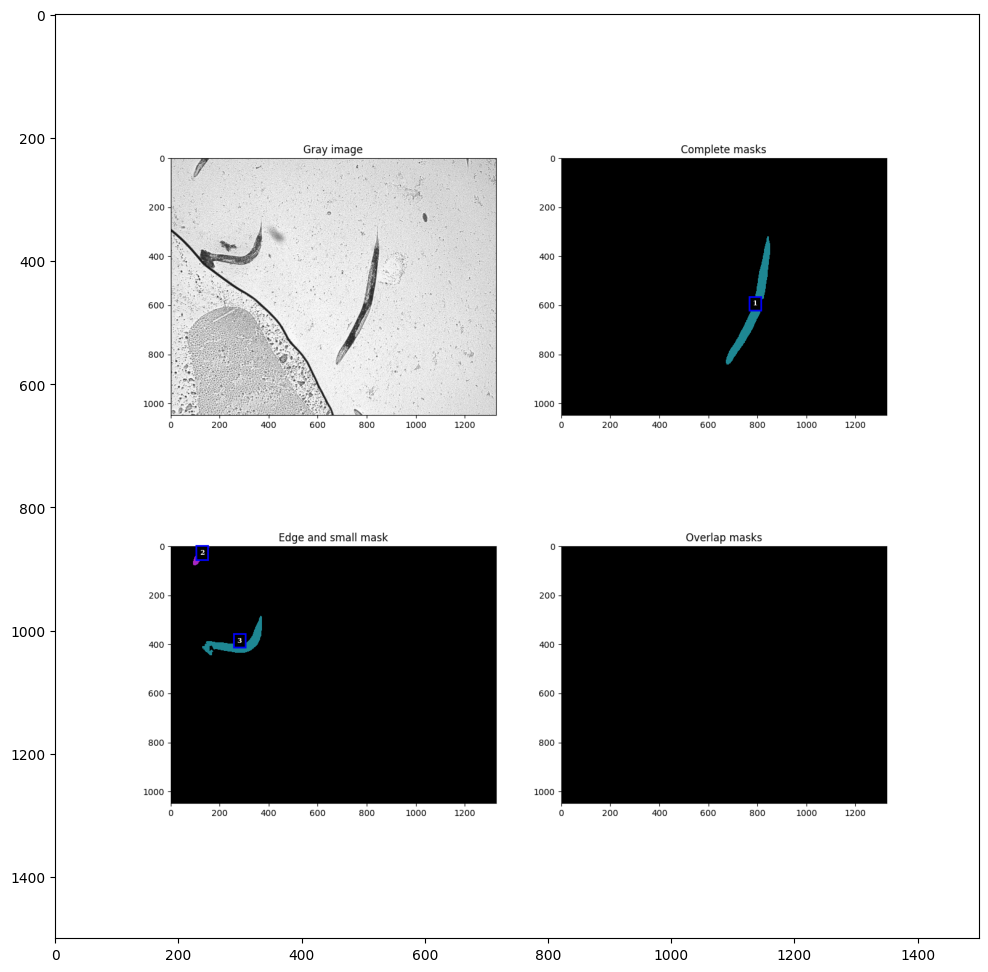

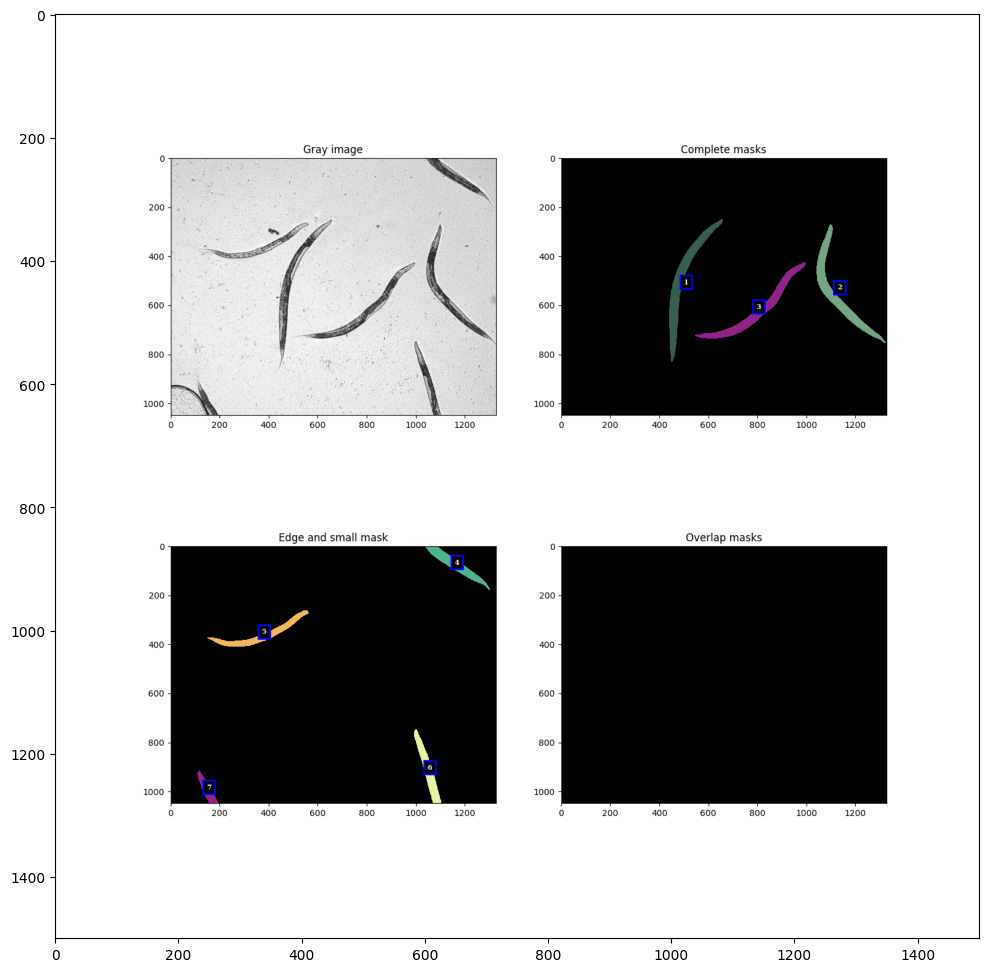

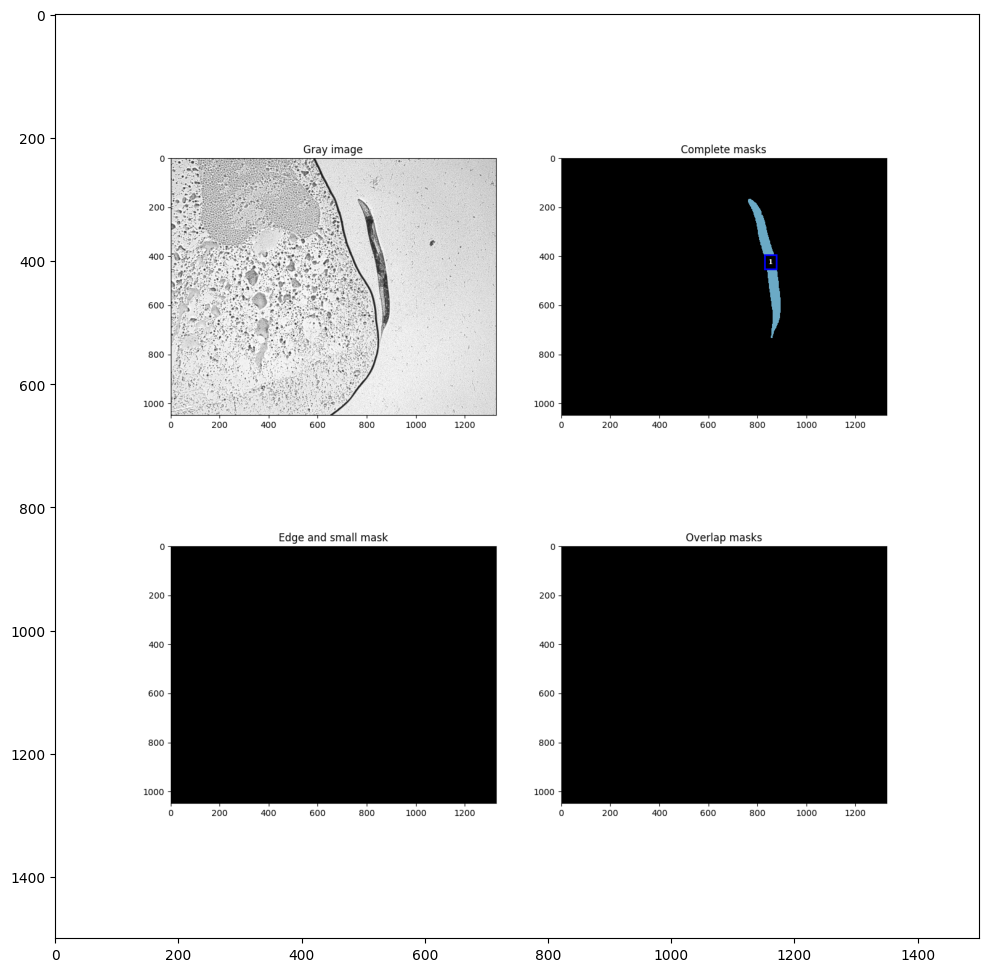

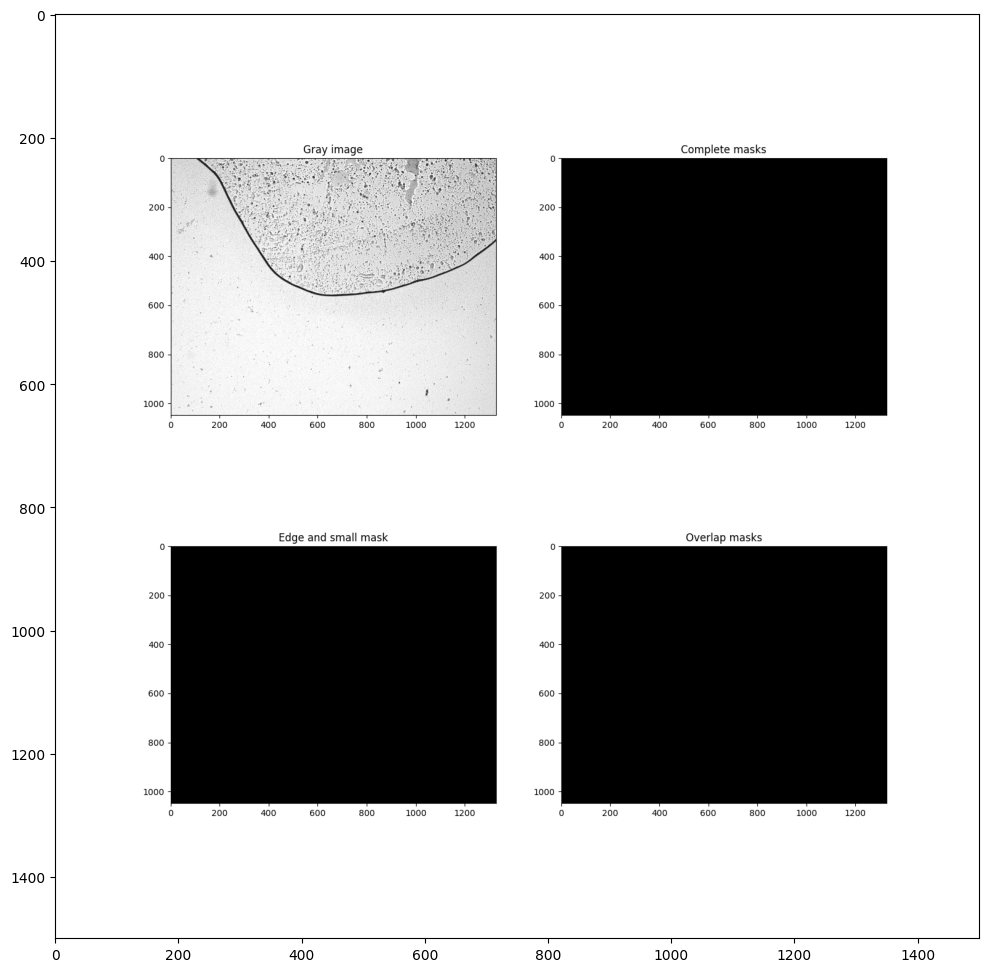

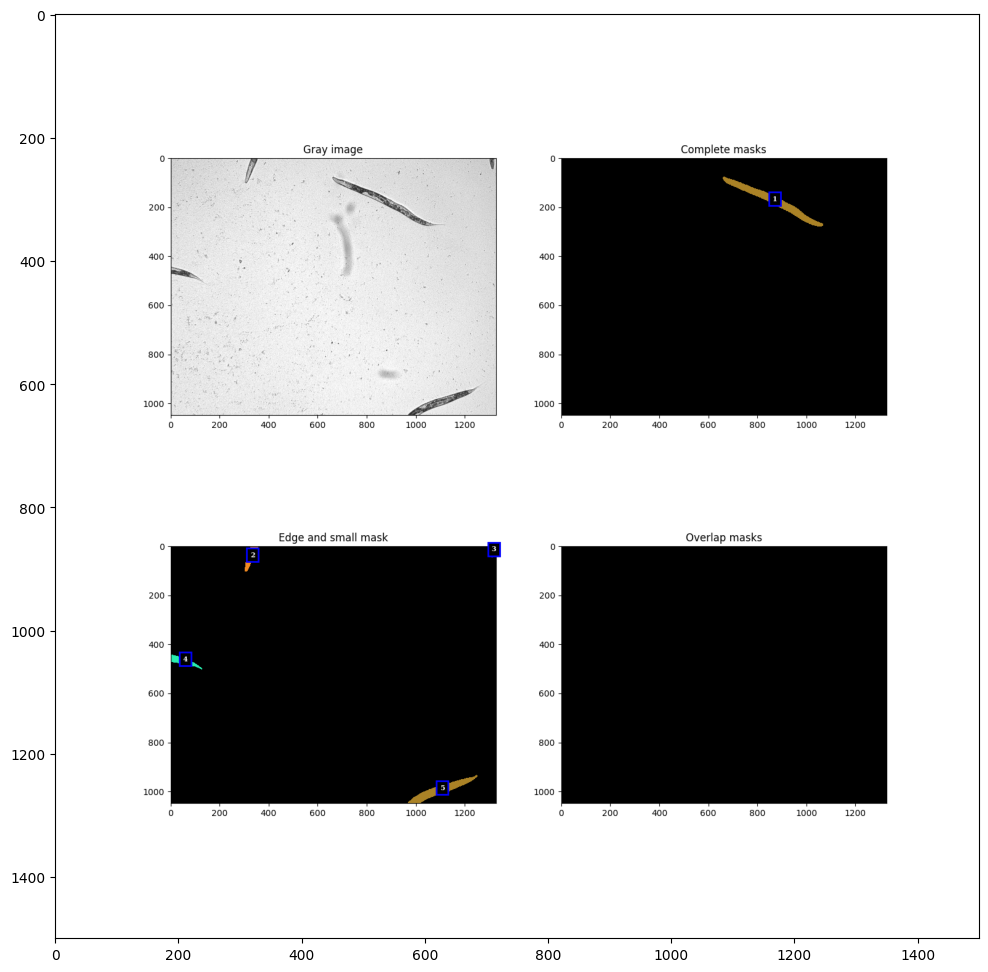

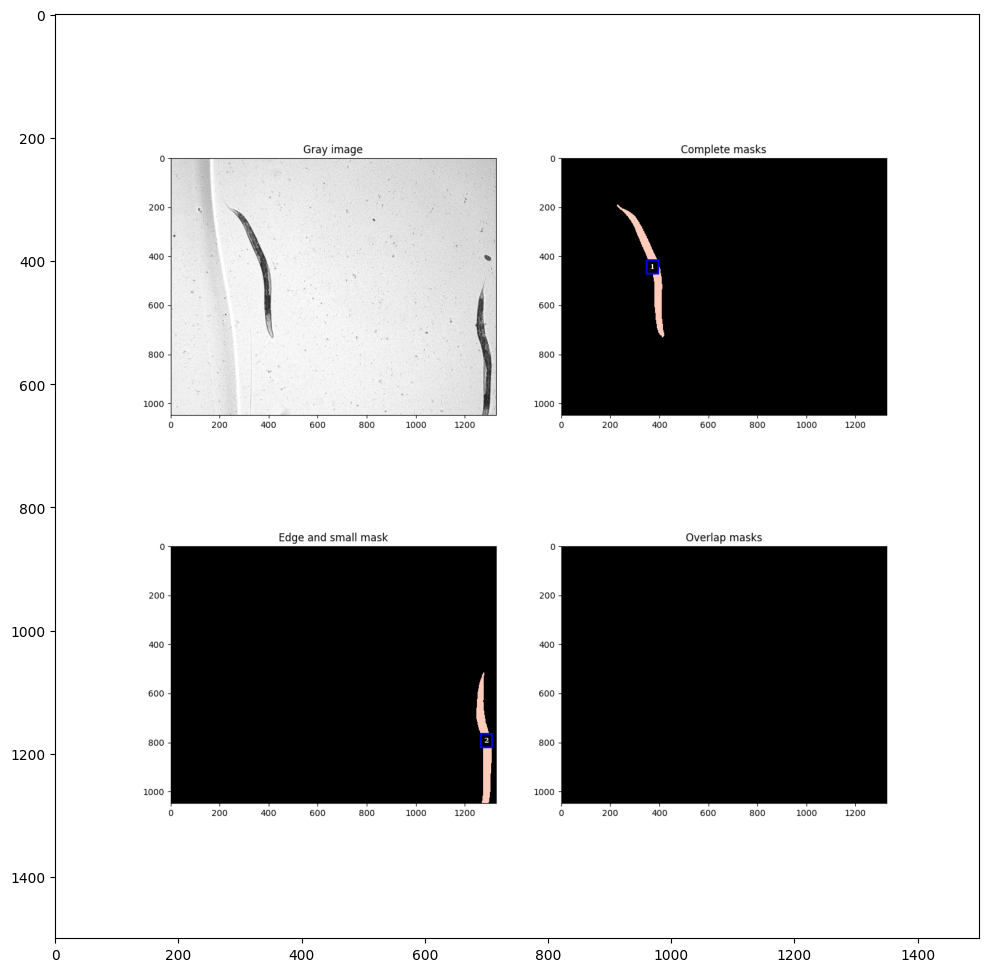

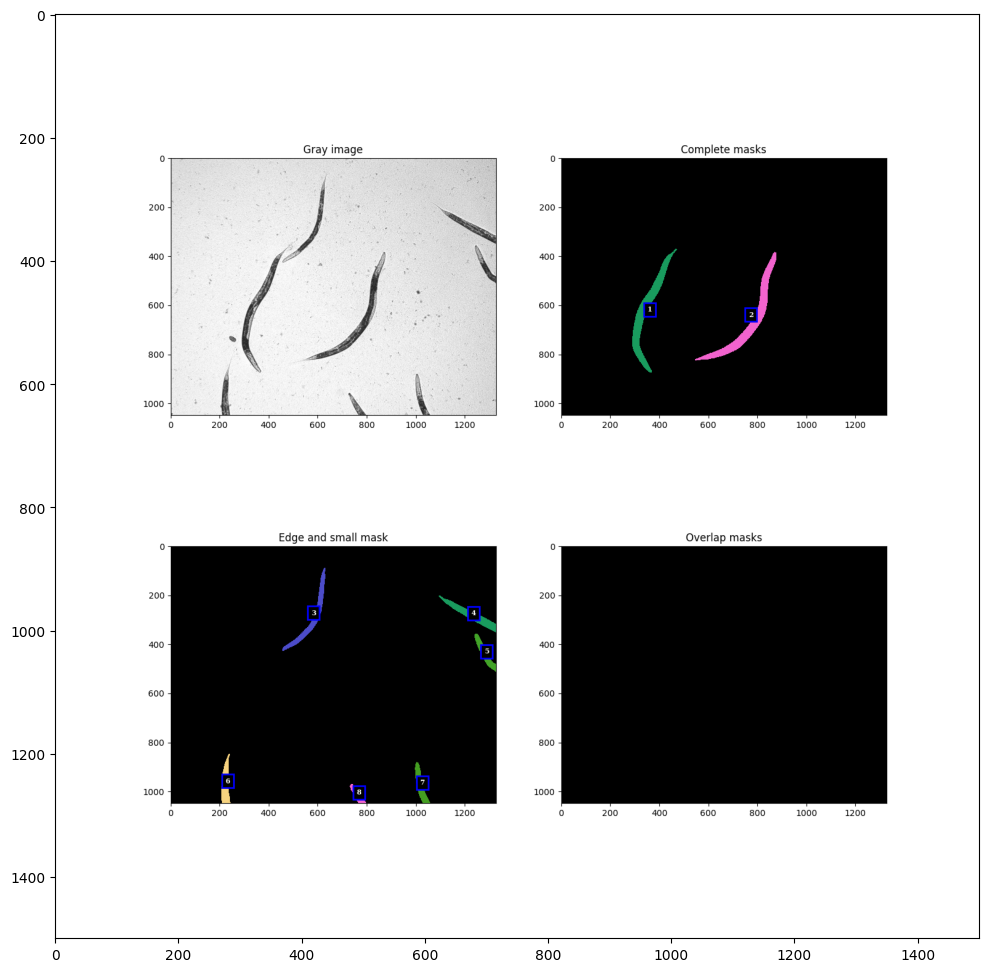

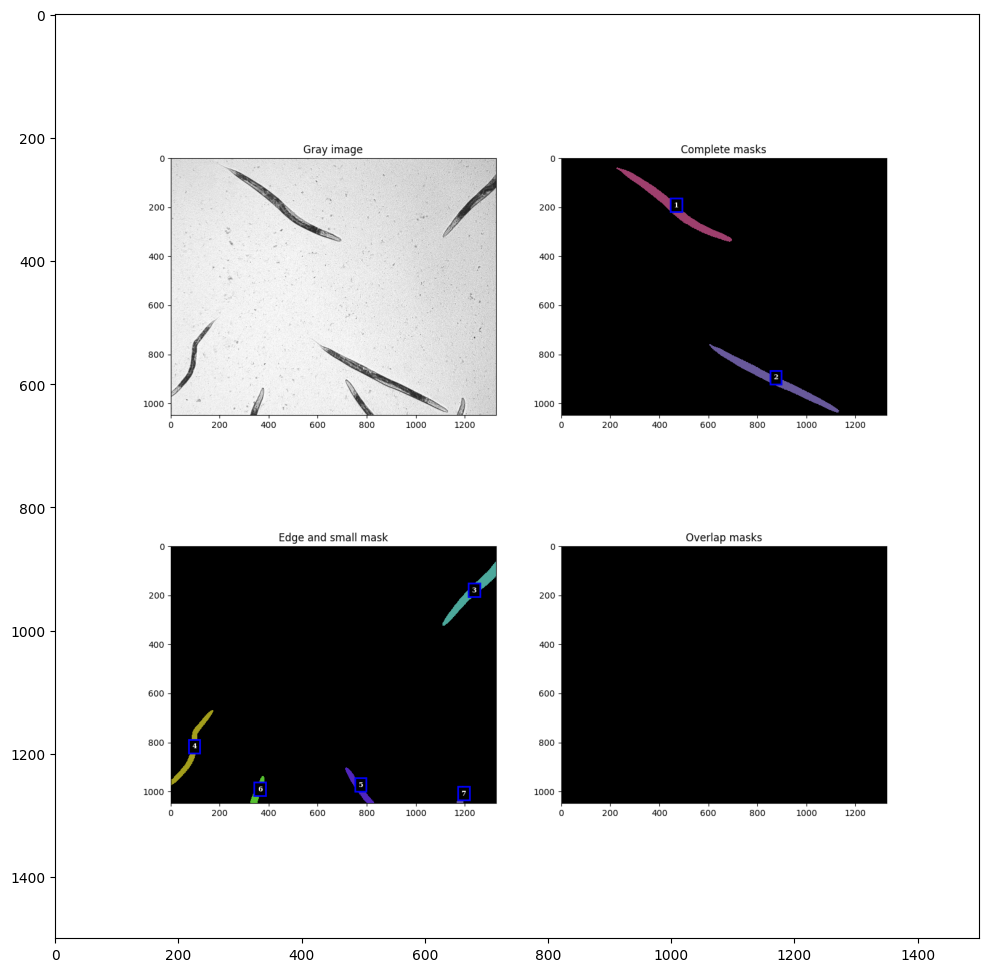

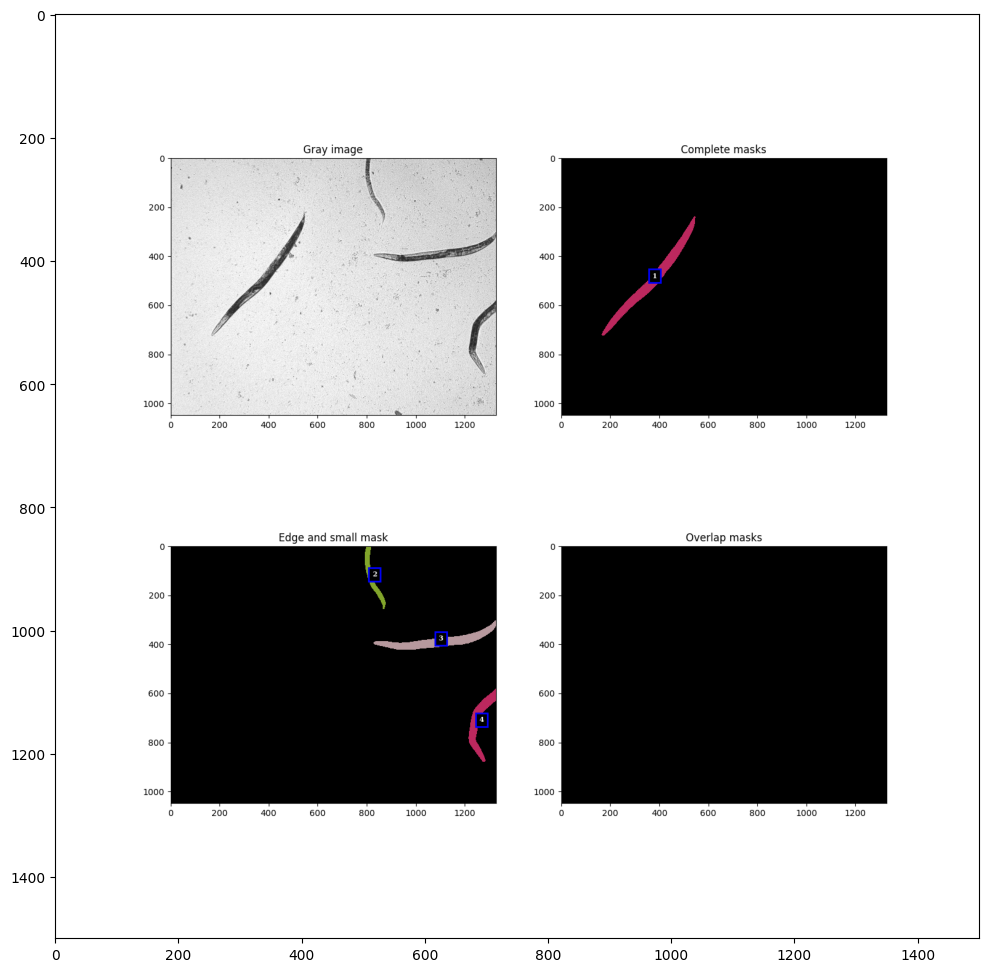

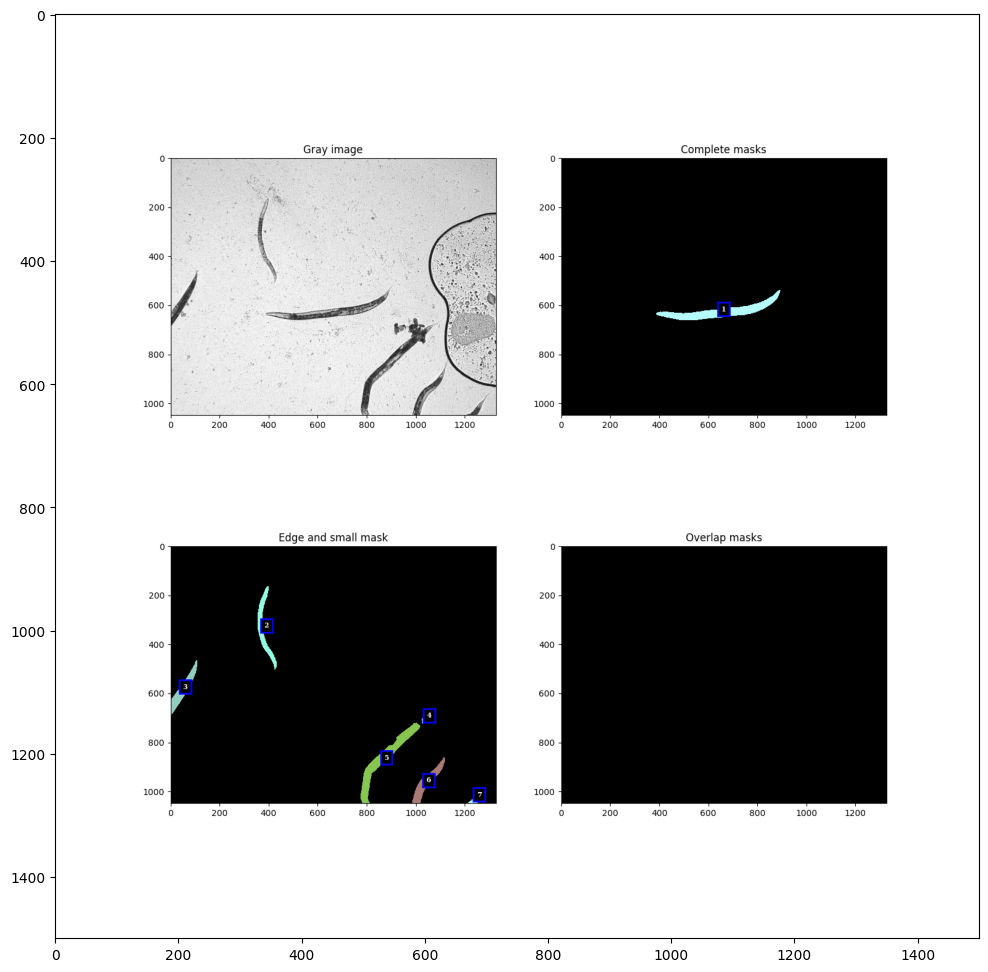

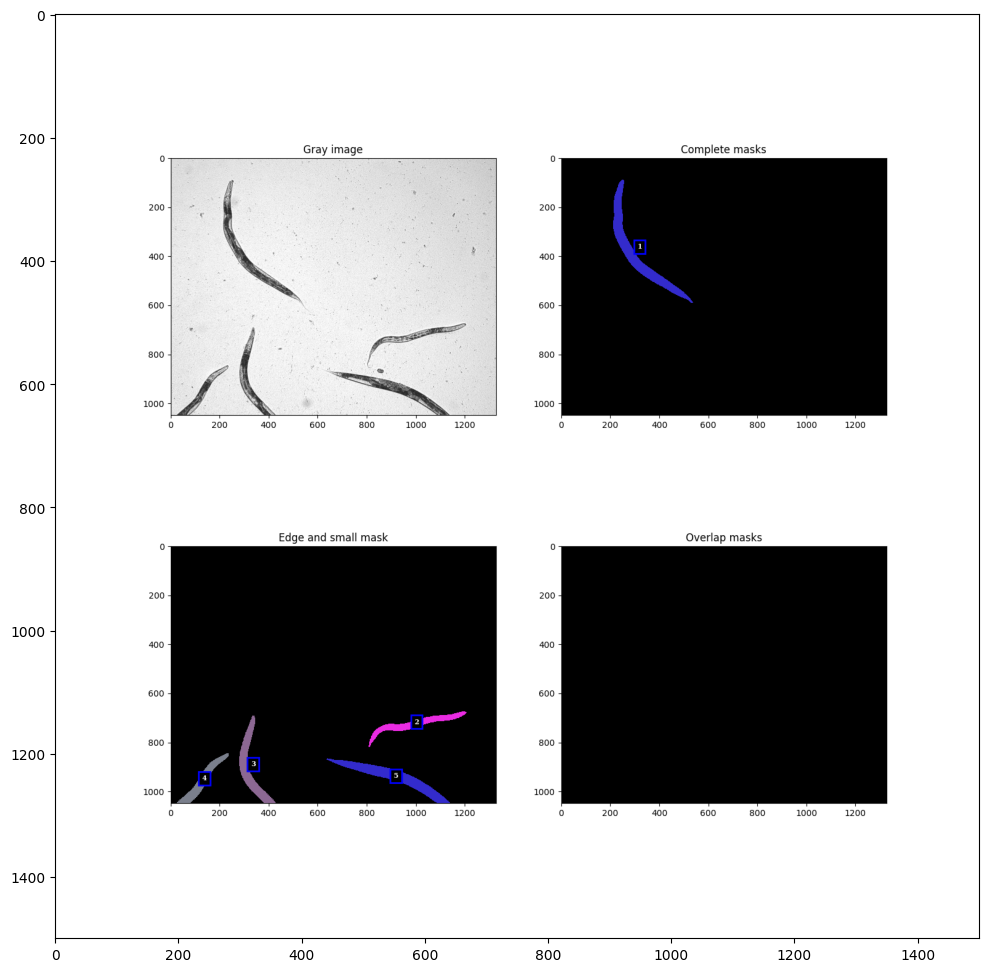

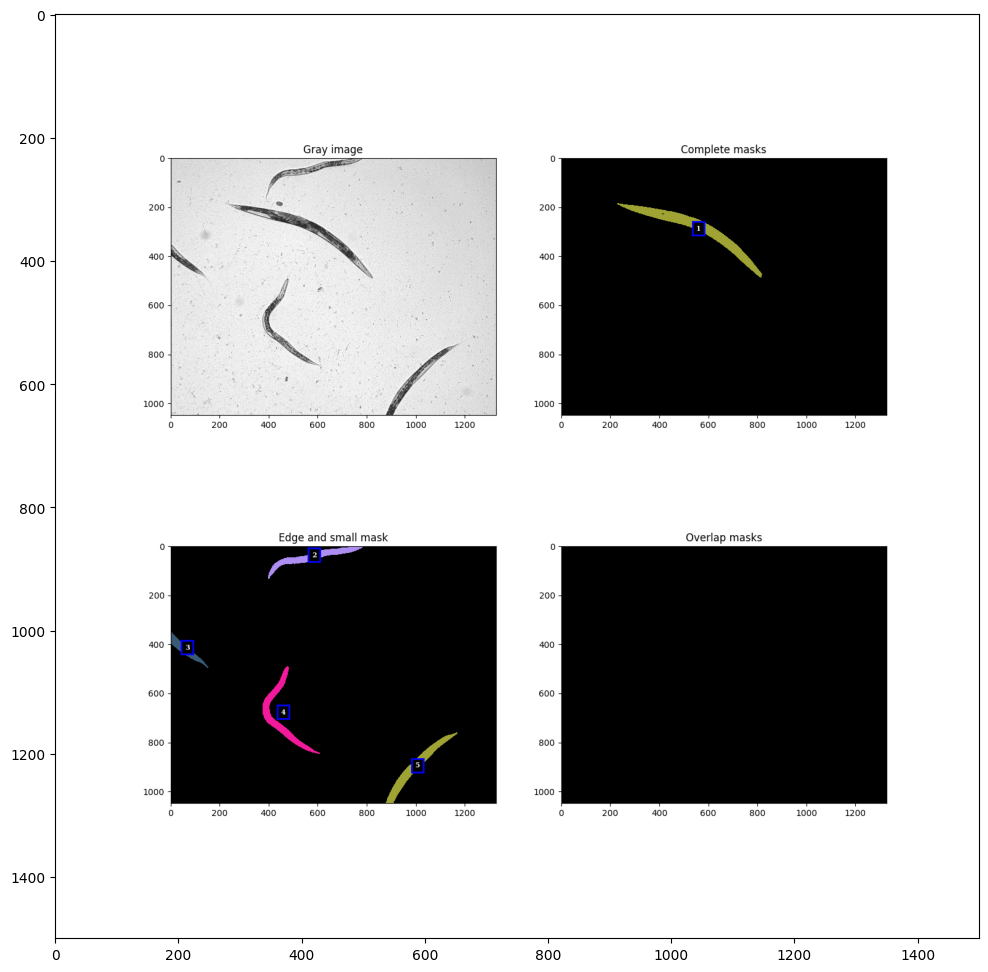

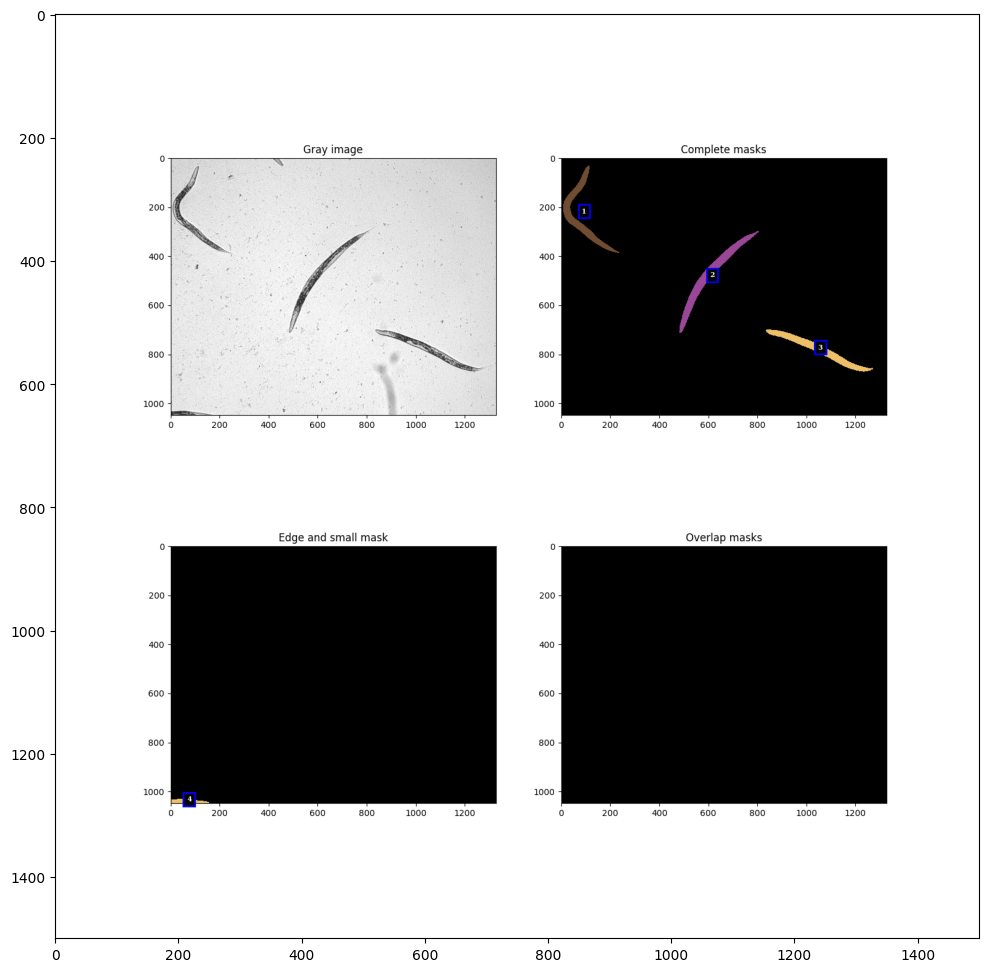

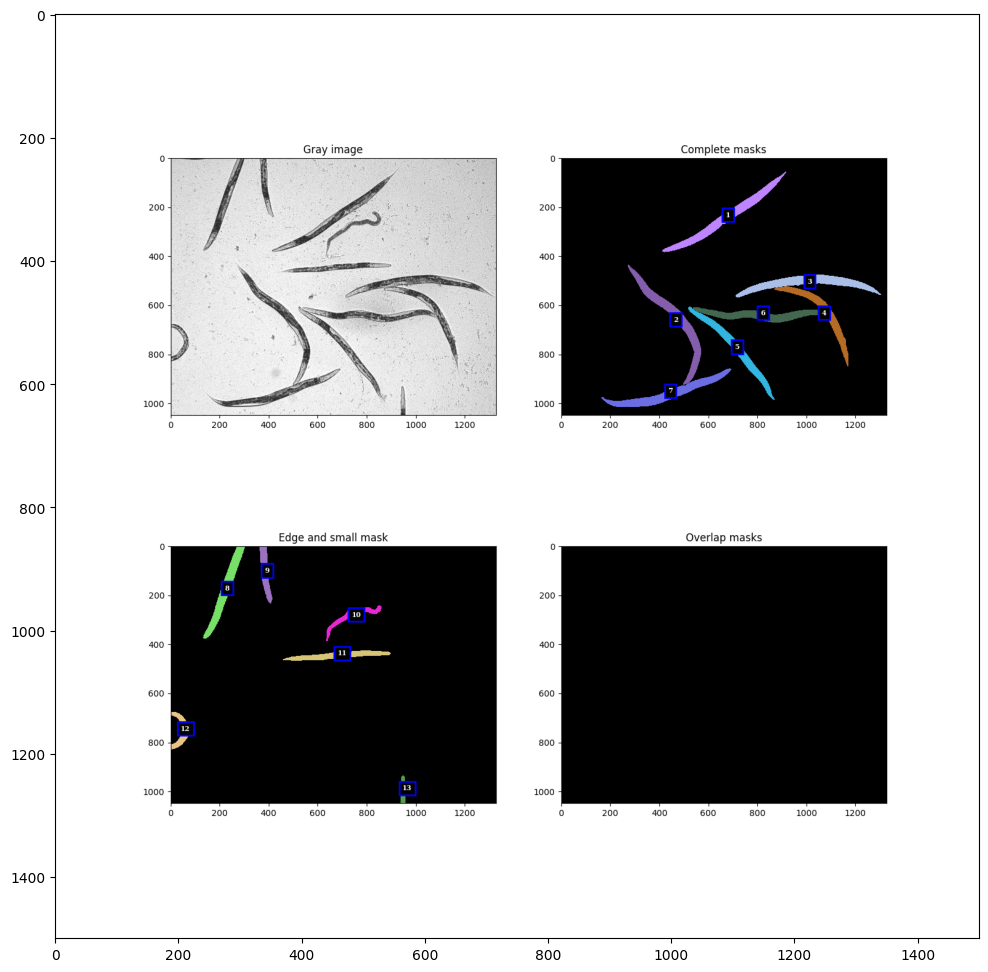

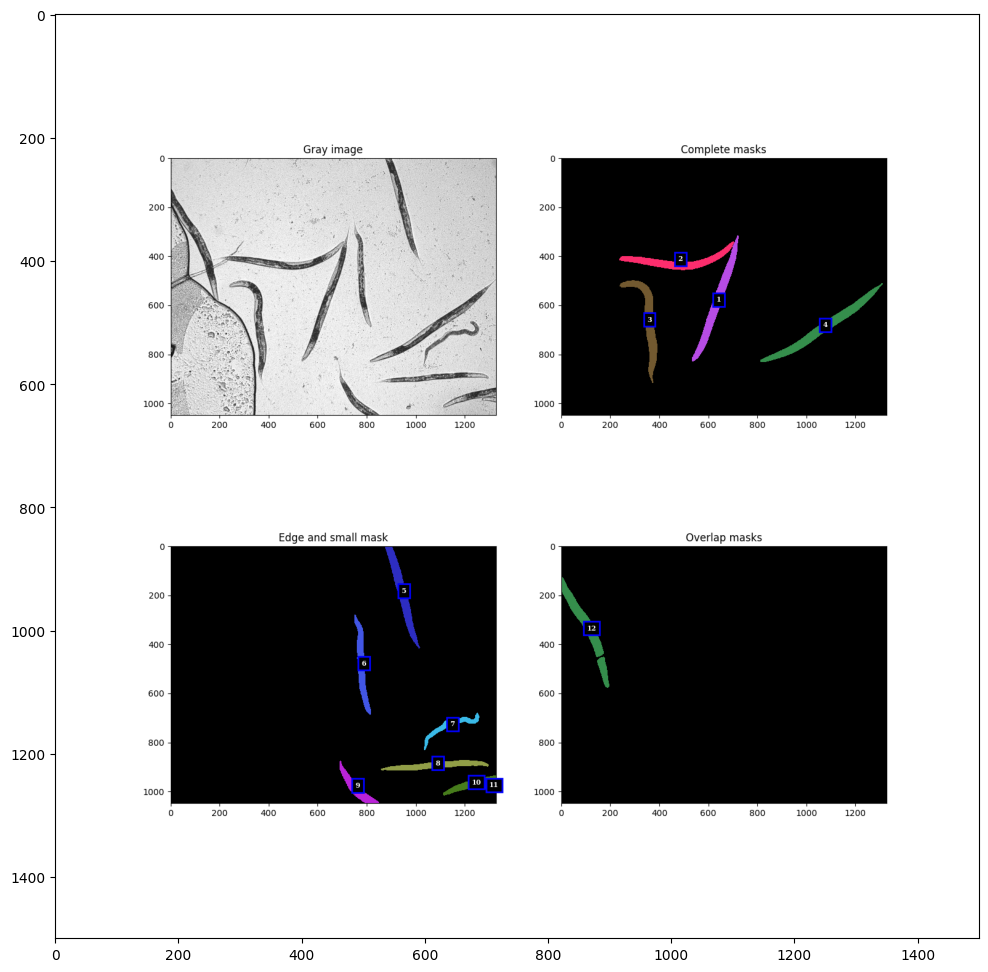

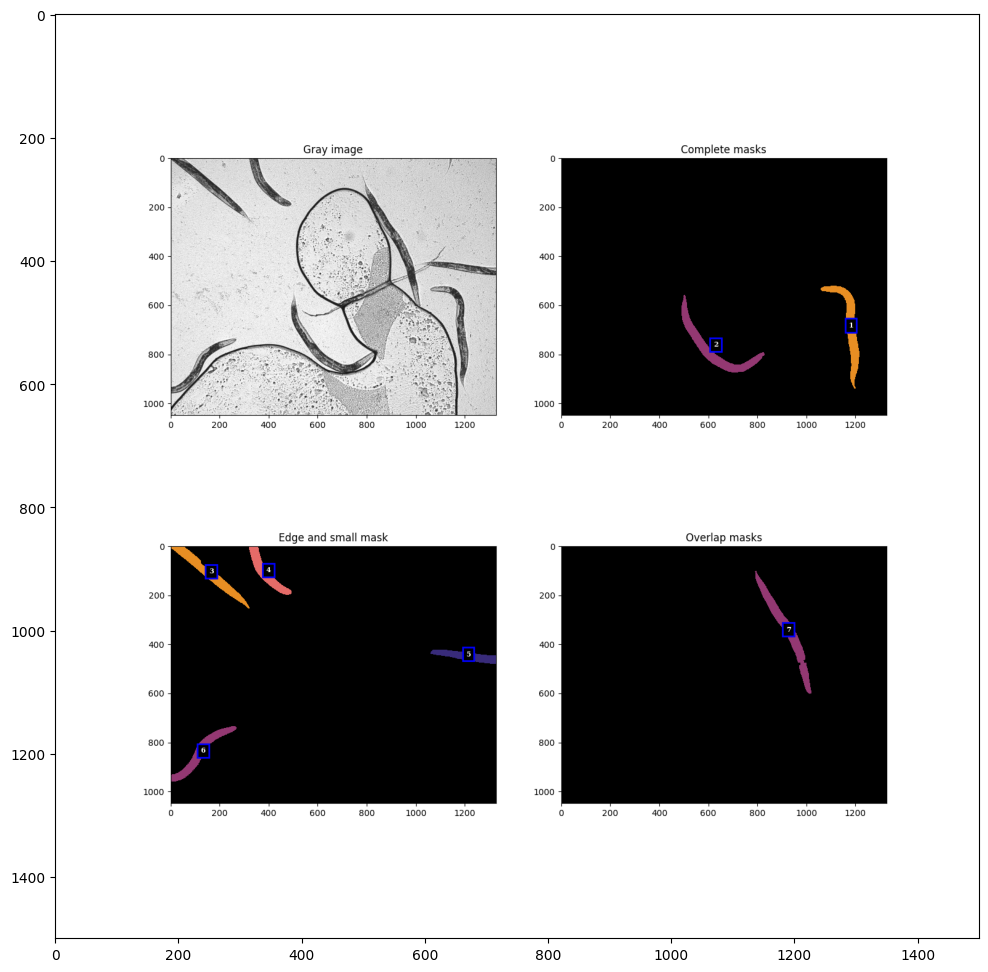

  0%|          | 0/37 [00:00<?, ?img/s]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (1).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (1).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (1).TIF


  3%|▎         | 1/37 [00:01<00:53,  1.48s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (10).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (10).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (10).TIF


  5%|▌         | 2/37 [00:03<01:01,  1.74s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (11).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (11).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (11).TIF


  8%|▊         | 3/37 [00:04<00:47,  1.39s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (12).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (12).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (12).TIF


 11%|█         | 4/37 [00:05<00:40,  1.23s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (13).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (13).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (13).TIF


 14%|█▎        | 5/37 [00:06<00:38,  1.21s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (14).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (14).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (14).TIF


 16%|█▌        | 6/37 [00:07<00:37,  1.22s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (15).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (15).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (15).TIF


 19%|█▉        | 7/37 [00:08<00:34,  1.14s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (16).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (16).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (16).TIF


 22%|██▏       | 8/37 [00:09<00:30,  1.05s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (17).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (17).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (17).TIF


 24%|██▍       | 9/37 [00:10<00:29,  1.05s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (18).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (18).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (18).TIF


 27%|██▋       | 10/37 [00:11<00:27,  1.01s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (19).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (19).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (19).TIF


 30%|██▉       | 11/37 [00:13<00:29,  1.15s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (2).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (2).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (2).TIF


 32%|███▏      | 12/37 [00:15<00:34,  1.39s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (20).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (20).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (20).TIF


 35%|███▌      | 13/37 [00:16<00:30,  1.28s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (21).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (21).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (21).TIF


 38%|███▊      | 14/37 [00:17<00:29,  1.29s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (22).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (22).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (22).TIF


 41%|████      | 15/37 [00:18<00:26,  1.19s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (23).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (23).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (23).TIF


 43%|████▎     | 16/37 [00:19<00:22,  1.09s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (24).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (24).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (24).TIF


 46%|████▌     | 17/37 [00:22<00:36,  1.84s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (25).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (25).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (25).TIF


 49%|████▊     | 18/37 [00:23<00:29,  1.56s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (26).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (26).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (26).TIF


 51%|█████▏    | 19/37 [00:24<00:24,  1.35s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (27).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (27).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (27).TIF


 54%|█████▍    | 20/37 [00:25<00:20,  1.20s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (28).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (28).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (28).TIF


 57%|█████▋    | 21/37 [00:26<00:19,  1.20s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (29).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (29).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (29).TIF


 59%|█████▉    | 22/37 [00:27<00:16,  1.12s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (3).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (3).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (3).TIF


 62%|██████▏   | 23/37 [00:28<00:16,  1.16s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (30).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (30).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (30).TIF


 65%|██████▍   | 24/37 [00:29<00:13,  1.03s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (31).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (31).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (31).TIF


 68%|██████▊   | 25/37 [00:30<00:12,  1.03s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (32).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (32).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (32).TIF


 70%|███████   | 26/37 [00:31<00:10,  1.01img/s]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (33).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (33).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (33).TIF


 73%|███████▎  | 27/37 [00:32<00:10,  1.09s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (34).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (34).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (34).TIF


 76%|███████▌  | 28/37 [00:33<00:10,  1.11s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (35).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (35).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (35).TIF


 78%|███████▊  | 29/37 [00:34<00:08,  1.06s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (36).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (36).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (36).TIF


 81%|████████  | 30/37 [00:35<00:07,  1.05s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (37).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (37).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (37).TIF


 84%|████████▍ | 31/37 [00:36<00:06,  1.03s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (4).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (4).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (4).TIF


 86%|████████▋ | 32/37 [00:37<00:05,  1.01s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (5).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (5).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (5).TIF


 89%|████████▉ | 33/37 [00:38<00:03,  1.01img/s]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (6).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (6).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (6).TIF


 92%|█████████▏| 34/37 [00:40<00:03,  1.07s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (7).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (7).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (7).TIF


 95%|█████████▍| 35/37 [00:41<00:02,  1.19s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (8).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (8).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (8).TIF


 97%|█████████▋| 36/37 [00:42<00:01,  1.14s/img]

/content/drive/MyDrive/Eleganseg Test/Output/1_complete_mask/Test (9).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_overlap_mask/Test (9).TIF
/content/drive/MyDrive/Eleganseg Test/Output/1_edge_small_mask/Test (9).TIF


100%|██████████| 37/37 [00:43<00:00,  1.18s/img]


In [7]:
#@title **Begin post-processing**
#@markdown Check if you want to split into paralel subprocesses (depending on available RAM).
Parallel_process = True #@param {type:"boolean"}

#@markdown Enter the number of subprocesses to split (depending on available RAM).
N_process = 4 #@param {type:"slider", min:2, max:16, step:1}

area_percentage = 60
area_min = 600
kernel_size = 3
angle_value = 20

path_summary_save = '0_summary_results'
path_complete_mask = '1_complete_mask'
path_edge_small_mask = '1_edge_small_mask'
path_overlap_mask = '1_overlap_mask'
path_all_rois_results = '1_all_rois_results'


path_summary_save = os.path.join(save_dir, path_summary_save)
path_complete_mask = os.path.join(save_dir, path_complete_mask)
path_edge_small_mask = os.path.join(save_dir, path_edge_small_mask)
path_overlap_mask = os.path.join(save_dir, path_overlap_mask)

print('Folder complete mask:', path_complete_mask)
print('Folder edge and small mask:', path_edge_small_mask)
print('Folder overlap masks:', path_overlap_mask)
print('Folder save_results:', path_summary_save)

import numpy as np
from skimage import measure
from joblib import Parallel, delayed

args = {'Parallel_process': Parallel_process,
        'path_images': test_images,
        'path_SEGMENTATION': path_SEGMENTATION,
        'path_SKELETON': path_SKELETON,
        'path_complete_mask': path_complete_mask,
        'path_edge_small_mask': path_edge_small_mask,
        'path_overlap_mask': path_overlap_mask,
        'path_summary_save': path_summary_save,
        'area_percentage': area_percentage,
        'area_min': area_min,
        'kernel_size': kernel_size,
        'angle_value': angle_value
        }

def post_processing(args, name_image):
    name_image_ = name_image.split('.')[0]
    name_image_save = name_image_ + '.bmp'
    seg_path=os.path.join(args['path_SEGMENTATION'], name_image_save)
    image_seg = cv2.imread(seg_path)

    save_path = os.path.join(args['path_summary_save'] + name_image_) + '.png'
    if not os.path.exists(save_path):
        skl_path=os.path.join(args['path_SKELETON'], name_image_save)
        image_skl = cv2.imread(skl_path)
        image_skl = (cv2.cvtColor(image_skl, cv2.COLOR_BGR2GRAY) > 0) * 255

        area_min = args['area_min']
        angle_value = args['angle_value']
        kernel_size = args['kernel_size']
        area_percentage = args['area_percentage']

        path_images = args['path_images']
        path_complete_mask = args['path_complete_mask']
        path_edge_small_mask = args['path_edge_small_mask']
        path_overlap_mask = args['path_overlap_mask']
        path_summary_save = args['path_summary_save']

        if not os.path.exists(path_complete_mask):
            try:
              os.makedirs(path_complete_mask)
            except FileExistsError:
              pass

        if not os.path.exists(path_edge_small_mask):
            try:
              os.makedirs(path_edge_small_mask)
            except FileExistsError:
              pass

        if not os.path.exists(path_overlap_mask):
            try:
              os.makedirs(path_overlap_mask)
            except FileExistsError:
              pass

        if not os.path.exists(path_summary_save):
            try:
              os.makedirs(path_summary_save)
            except FileExistsError:
              pass


        # ***************** Improve edge detection ****************************************************
        edge_final = check_edge_worms(image_seg, kernel_size)

        # ***************** none overlappings and overlappings *******************************************
        none_overlappings, overlapping = obtain_overlappings(image_seg, edge_final, kernel_size + 2)
        labels_overlapping = measure.label(overlapping, background=0)
        labels_none_overlapping = measure.label(none_overlappings, background=0)

        # ************************** None-overlappings ***************************************************
        true_overlaps = check_overlapping(labels_overlapping, labels_none_overlapping)
        mask_worms = get_none_overlapping(labels_none_overlapping, true_overlaps, area_min, kernel_size)  # none-overl
        mask_worms_Dims = worms2NDims(mask_worms, kernel_size + 2)  # each dimension is a worm
        results_masks_NO = check_noneOverlapping(mask_worms_Dims, area_percentage)  # Check good/bad masks

        # ************************** overlappings ********************************************************
        mask_overlaps_Dims = overlapping_worms(true_overlaps, mask_worms, labels_overlapping,
                                               labels_none_overlapping, image_skl, area_min,
                                               kernel_size+2, angle_value)

        # ***************************** Save imgs results *****************************************************
        name_image_final = os.path.join(path_summary_save, name_image_) + '.png'
        path_image_gray = os.path.join(path_images, name_image)
        image_gray = imread_image(path_image_gray)  # read gray image
        if len(image_gray.shape) > 2:
            image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
        save_results_mask(name_image_final, image_gray, results_masks_NO, mask_overlaps_Dims, 1)  # RGB
        complete_mask_name = os.path.join(path_complete_mask, name_image)
        save_mask_tif(complete_mask_name, results_masks_NO['worms_good'])
        edge_small_mask_name= os.path.join(path_edge_small_mask,name_image)
        save_mask_tif(edge_small_mask_name, results_masks_NO['worms_bads'])
        overlap_mask_name=os.path.join(path_overlap_mask, name_image)
        save_mask_tif(overlap_mask_name, mask_overlaps_Dims)

warnings.filterwarnings("ignore", message=".*OME series cannot handle discontiguous storage")

if Parallel_process:
    Parallel(n_jobs=N_process, verbose=1, backend='multiprocessing')(
        delayed(post_processing)(args, name_image) for name_image in list_images)
else:
    with tqdm(total=len(list_images), unit='img') as pbar:
        for name_image in list_images:
            post_processing(args, name_image)
            pbar.update(1)

## Show results masks
for name_image_showed in list_images:
  name_image_ = name_image_showed.split('.')[0]
  name_image_result = os.path.join(path_summary_save, name_image_) + '.png'
  image_result = cv2.imread(name_image_result)

  plt.figure(figsize=(15, 15))
  plt.imshow(image_result)
  fig = plt.gcf()
  fig.set_size_inches(12, 12)
  plt.show()

## Save all ROIS just in case

path_all_rois_results = os.path.join(save_dir, path_all_rois_results)

from utils import list_files, save_mask_rois
if not os.path.exists(path_all_rois_results):
    os.makedirs(path_all_rois_results)

list_images = sorted(list_files(test_images, end_gray_image))
with tqdm(total=len(list_images), unit='img') as pbar:
    for name_image in list_images:
        path_good_mask = os.path.join(path_complete_mask, name_image)
        print(path_good_mask)
        image_good_mask = read_tiff_mask(path_good_mask)
        path_overlap_mask_mask=os.path.join(path_overlap_mask, name_image)
        print(path_overlap_mask_mask)
        image_overlap_mask = read_tiff_mask(path_overlap_mask_mask)
        path_reject_mask=os.path.join(path_edge_small_mask, name_image)
        print(path_reject_mask)
        image_reject_mask = read_tiff_mask(path_reject_mask)
        name_image_ = name_image.split('.')[0]
        image_total_mask=np.concatenate((image_good_mask,image_overlap_mask,image_reject_mask),axis=0)
        name_zip_save = name_image_ + '.zip'
        path_zip_save = os.path.join(path_all_rois_results, name_zip_save)
        save_mask_rois(path_zip_save, image_total_mask)
        pbar.update(1)

Image selected: Test (9).TIF
Worms good:  ['1', '2', '7']
Worms bad:  ['3', '4', '5', '6']


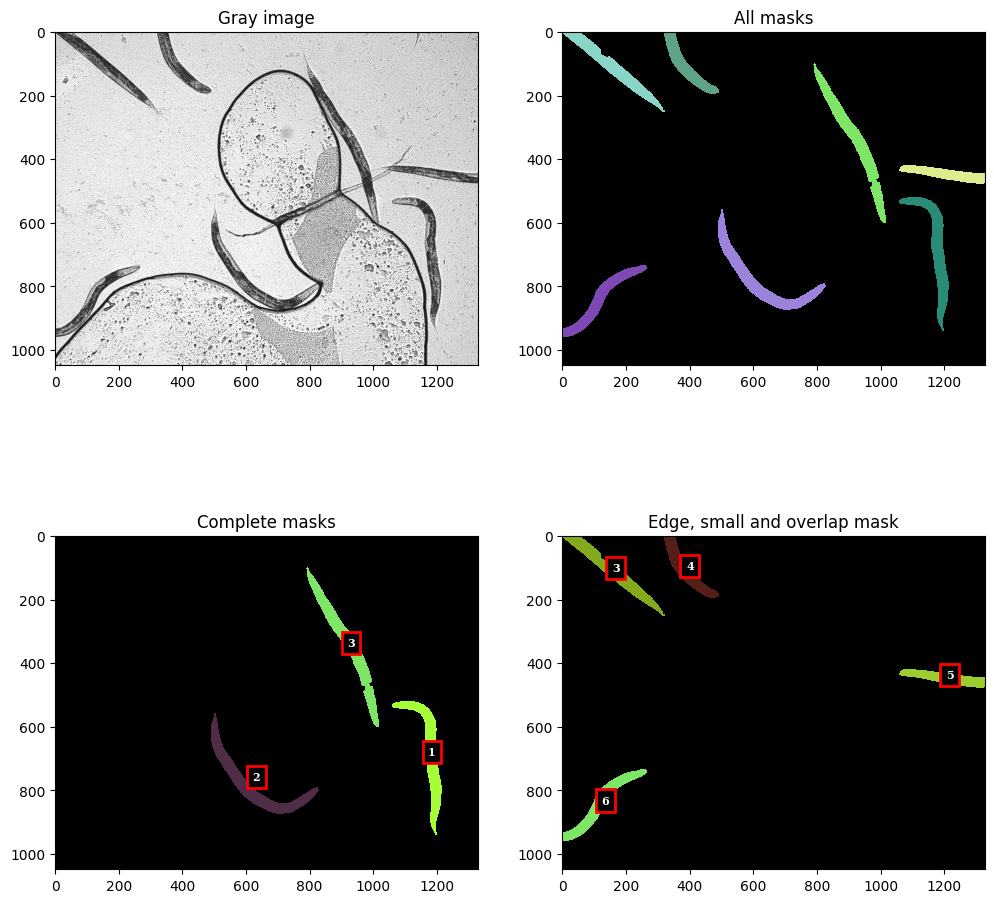

In [ ]:
#@title **Mask correction, saving and export**
#@markdown Correct mask curation/designation by designating the worms you want to keep.
import warnings
warnings.filterwarnings('ignore')

name_image_change = '' #@param {type:"string",placeholder:"File name (with extension) of image for manual correction"}
print('Image selected:', name_image_change)
index_images = '' #@param {type:"string",placeholder:"Type the numbers of the worms you want from the summary results"}

image_complete_mask_path = path_complete_mask + name_image_change
image_edge_small_mask_path = path_edge_small_mask + name_image_change

image_complete_mask_before = read_tiff_mask(image_complete_mask_path)
image_edge_small_mask_before = read_tiff_mask(image_edge_small_mask_path)

masK_predict_all = np.concatenate((image_complete_mask_before, image_edge_small_mask_before), axis=0)

try:
  image_overlap_mask = path_overlap_mask + name_image_change
  image_overlap_mask = read_tiff_mask(image_overlap_mask)
  masK_predict_all = np.concatenate((masK_predict_all, image_overlap_mask), axis=0)
except:
  rt = -1

all_elements = []
for i in range(1, masK_predict_all.shape[0] + 1):
    all_elements.append(str(i))

index_images = index_images.split(',')

all_elements = all_elements + index_images

index_bad = [i for i in all_elements if all_elements.count(i) == 1]
print('Worms good: ', index_images)
print('Worms bad: ', index_bad)
worms_true = np.zeros((len(index_images), masK_predict_all.shape[1], masK_predict_all.shape[2]), np.int8)
for i in range(len(index_images)):
    index = int(index_images[i])
    worms_true[i, :, :] = masK_predict_all[index - 1, :, :]

worms_bad = np.zeros((len(index_bad), masK_predict_all.shape[1], masK_predict_all.shape[2]), np.int8)
for i in range(len(index_bad)):
    index = int(index_bad[i])
    worms_bad[i, :, :] = masK_predict_all[index - 1, :, :]

worms_true = (worms_true != 0) * 255
worms_bad = (worms_bad != 0) * 255

worms_all_true, new_map = Ndims2image(worms_true, 1)
worms_all_bad, _ = Ndims2image(worms_bad, 1)

centroid_predict_true, label_predict_true = get_centroid(worms_true, 1)
centroid_predict_bad, label_predict_bad = get_centroid(worms_bad, len(index_images))


tifffile.imwrite(image_complete_mask_path, worms_true.astype(np.uint8))
tifffile.imwrite(image_edge_small_mask_path, worms_bad.astype(np.uint8))
try:
  os.remove(path_overlap_mask + name_image_change)
except:
  print('Files does not exist')


path_image_gray = test_images + name_image_change
image_gray = imread_image(path_image_gray)  # read gray image
if len(image_gray.shape) > 2:
    image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
worms_all, new_map = Ndims2image(masK_predict_all, 1)

# show images results
font = {'family': 'serif',
        'color': 'white',
        'weight': 'bold',
        'size': 8,
        }

bbox = {'facecolor': 'black',
        'edgecolor': 'red',
        'linewidth': 2
        }

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax1.title.set_text('Gray image')
ax1.imshow(image_gray, cmap='gray', vmin=0, vmax=255)

ax2 = fig.add_subplot(222)
ax2.title.set_text('All masks')
ax2.imshow(worms_all, cmap=new_map, interpolation='None')

ax3 = fig.add_subplot(223)
ax3.title.set_text('Complete masks')
ax3.imshow(worms_all_true, cmap=new_map, interpolation='None')
for i in range(len(centroid_predict_true)):
    ax3.text(centroid_predict_true[i][1], centroid_predict_true[i][0], label_predict_true[i], fontdict=font, bbox=bbox)

ax4 = fig.add_subplot(224)
ax4.title.set_text('Edge, small and overlap mask')
ax4.imshow(worms_all_bad, cmap=new_map, interpolation='None')
for i in range(len(centroid_predict_bad)):
    ax4.text(centroid_predict_bad[i][1], centroid_predict_bad[i][0], label_predict_bad[i], fontdict=font, bbox=bbox)

name_image_change_ = name_image_change.split('.')[0]
name_image_result = path_summary_save + name_image_change_ + 'Corrected.jpg'
plt.savefig(name_image_result)

fig = plt.gcf()
fig.set_size_inches(12, 12)

In [ ]:
#@title **Save curated rois**
#@markdown Save complete mask in rois
folder_rois_results = '2_curated_rois_results' #@param {type:"string"}
folder_rois_results = save_dir + '/' + folder_rois_results + '/'
print(folder_rois_results)

from utils import list_files, save_mask_rois
if not os.path.exists(folder_rois_results):
    os.makedirs(folder_rois_results)

list_images = sorted(list_files(path_complete_mask, end_gray_image))
with tqdm(total=len(list_images), unit='img') as pbar:
    for name_image in list_images:
        image_good_mask = path_complete_mask + name_image
        image_good_mask = read_tiff_mask(image_good_mask)
        name_image_ = name_image.split('.')[0]
        name_zip_save = folder_rois_results + name_image_ + '.zip'
        save_mask_rois(name_zip_save, image_good_mask)
        pbar.update(1)

/content/drive/MyDrive/Eleganseg Test/Output//2_rois_results/


100%|██████████| 37/37 [00:04<00:00,  8.11img/s]
